In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import FunctionTransformer

import matplotlib.pyplot as plt
import itertools
import json

# Датасет

In [2]:
df = pd.read_csv('../data/data_preprocess_2_attempt.tsv', sep='\t')
df

,price_rub,weight_g,kcal_per_100g,proteins_g_per_100g,fats_g_per_100g,carbs_g_per_100g,shelf_life_days,storage_temp_min_c,storage_temp_max_c,Россия,...,ТПК НВН,"ООО ""ПРО ВКУС","ООО ""МИРЛИС","ООО ""СТУДИЯ ВКУСА","ООО ""КРОХА","ООО ""ВКУСТЕХ","ООО ""ПЕЧКА ВЫПЕЧКА","ООО ""ПРОМЫШЛЕННАЯ КУЛИНАРИЯ",Other Manifactures,score
0,-0.051095,-0.135,0.316251,-1.064516,0.891263,0.163035,0.0,0.431373,0.25,1,...,0,0,1,0,0,0,0,0,0,-1
1,-0.489051,1.765,-1.475993,-1.000000,-0.981772,-0.802634,0.0,0.431373,0.25,1,...,0,0,1,0,0,0,0,0,0,1
2,0.313869,0.065,-0.253463,-0.193548,-0.277813,0.169306,0.0,0.431373,0.25,1,...,0,0,0,0,0,0,0,0,0,-1
3,-0.284672,-0.135,0.094645,0.354839,-0.013828,0.250823,0.0,0.431373,0.25,1,...,0,0,0,0,0,0,0,0,0,1
4,-0.036496,0.365,-0.349492,0.741935,-0.277813,-0.357423,0.0,0.431373,0.25,1,...,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
961,9.744526,7.865,1.111080,0.777419,2.233815,-0.710456,-3.5,0.431373,0.25,1,...,0,0,0,0,0,0,0,0,0,-1
962,9.452555,7.865,1.151524,0.725806,1.894406,-0.240790,-3.5,0.431373,0.25,1,...,0,0,0,0,0,0,0,0,0,-1
963,-0.883212,-0.985,0.501847,0.612903,0.350723,0.432670,-1.0,0.431373,0.25,1,...,0,0,0,0,0,0,0,0,1,-1
964,-0.854015,-0.985,0.846260,0.500000,0.111879,1.329362,-1.0,0.431373,0.25,1,...,0,0,0,0,0,0,0,0,1,-1


In [3]:
train_val, test_df = train_test_split(df, test_size=0.15,  random_state=42, stratify=df["score"])
train_df, val_df = train_test_split(train_val, test_size=0.17,  random_state=42, stratify=train_val["score"])
print(train_df["score"].sum() / len(train_df))
print(val_df["score"].sum() / len(val_df))
print(test_df["score"].sum() / len(test_df))

-0.7004405286343612
-0.7
-0.696551724137931


In [4]:
def from_df_to_X_y(df, intercept=True):
    y = df["score"].to_numpy()
    df_without_score = df.drop(columns=["score"])
    X = df_without_score.to_numpy()
    if intercept:
        X = np.column_stack((np.ones((X.shape[0], 1)), X))
    return X, y

X_train, y_train = from_df_to_X_y(train_df)
X_val, y_val = from_df_to_X_y(val_df)
X_test, y_test = from_df_to_X_y(test_df)

# Модели

In [5]:
def drop_intercept(X):
    return X[:, 1:]

In [6]:
models = {
    "linreg_analytic": (
        "reg",
        LinearRegression(fit_intercept=False)
    ),
    "linreg_sgd": (
        "reg",
        SGDRegressor(
            loss="squared_error",
            max_iter=2000,
            tol=1e-3,
            fit_intercept=False,
            random_state=42
        )
    ),
    "tree": (
        "clf",
        DecisionTreeClassifier(random_state=42)
    ),
    "sampling": (
        "clf",
        BaggingClassifier(
            DecisionTreeClassifier(random_state=42),
            n_estimators=1,
            max_samples=0.5,
            bootstrap=True,
            n_jobs=-1,
            random_state=42
        )
    ),
    "bagging": (
        "clf",
        BaggingClassifier(
            DecisionTreeClassifier(random_state=42),
            n_estimators=50,
            bootstrap=True,
            n_jobs=-1,
            random_state=42
        )
    ),
    "filtering": (
        "clf",
        make_pipeline(
            FunctionTransformer(drop_intercept),
            SelectKBest(f_classif, k=min(20, X_train.shape[1] - 1)),
            DecisionTreeClassifier(random_state=42)
        )
    ),
    "random_subsampling": (
        "clf",
        BaggingClassifier(
            DecisionTreeClassifier(random_state=42),
            n_estimators=50,
            max_samples=0.7,
            bootstrap=False,
            n_jobs=-1,
            random_state=42
        )
    ),
    "random_forest": (
        "clf",
        RandomForestClassifier(
            n_estimators=200,
            n_jobs=-1,
            random_state=42
        )
    ),
        "gradient_boosting": (
        "clf",
        GradientBoostingClassifier(
            n_estimators=200,
            learning_rate=0.1,
            max_depth=3,
            random_state=42
        )
    ),
}

In [7]:
def pred(model, kind, X):
    if kind == "reg":
        return np.where(model.predict(X) >= 0, 1, -1)
    return model.predict(X)

for name, (kind, model) in models.items():
    model.fit(X_train, y_train)
    train_acc = accuracy_score(y_train, pred(model, kind, X_train))
    val_acc = accuracy_score(y_val, pred(model, kind, X_val))
    test_acc = accuracy_score(y_test, pred(model, kind, X_test))
    print(
        f"{name}: "
        f"train={train_acc:.4f}, "
        f"val={val_acc:.4f}, "
        f"test={test_acc:.4f}"
    )


linreg_analytic: train=0.8561, val=0.8571, test=0.8621
linreg_sgd: train=0.5683, val=0.5714, test=0.6621
tree: train=0.9985, val=0.7429, test=0.7793
sampling: train=0.8620, val=0.6786, test=0.7517
bagging: train=0.9985, val=0.8214, test=0.8414
filtering: train=0.9765, val=0.7429, test=0.8207
random_subsampling: train=0.9985, val=0.8143, test=0.8345
random_forest: train=0.9985, val=0.8643, test=0.8483
gradient_boosting: train=0.9736, val=0.8429, test=0.8207


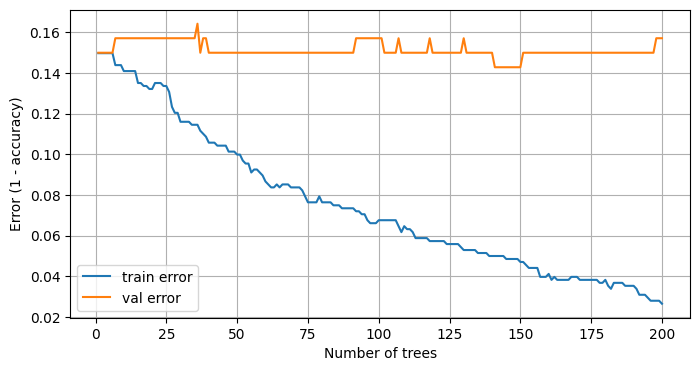

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

gb = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)
gb.fit(X_train, y_train)

train_errors = []
val_errors = []

for y_pred_train, y_pred_val in zip(
    gb.staged_predict(X_train),
    gb.staged_predict(X_val)
):
    train_errors.append(1.0 - accuracy_score(y_train, y_pred_train))
    val_errors.append(1.0 - accuracy_score(y_val, y_pred_val))

iters = np.arange(1, len(train_errors) + 1)

plt.figure(figsize=(8, 4))
plt.plot(iters, train_errors, label="train error")
plt.plot(iters, val_errors, label="val error")
plt.xlabel("Number of trees")
plt.ylabel("Error (1 - accuracy)")
plt.legend()
plt.grid(True)
plt.show()


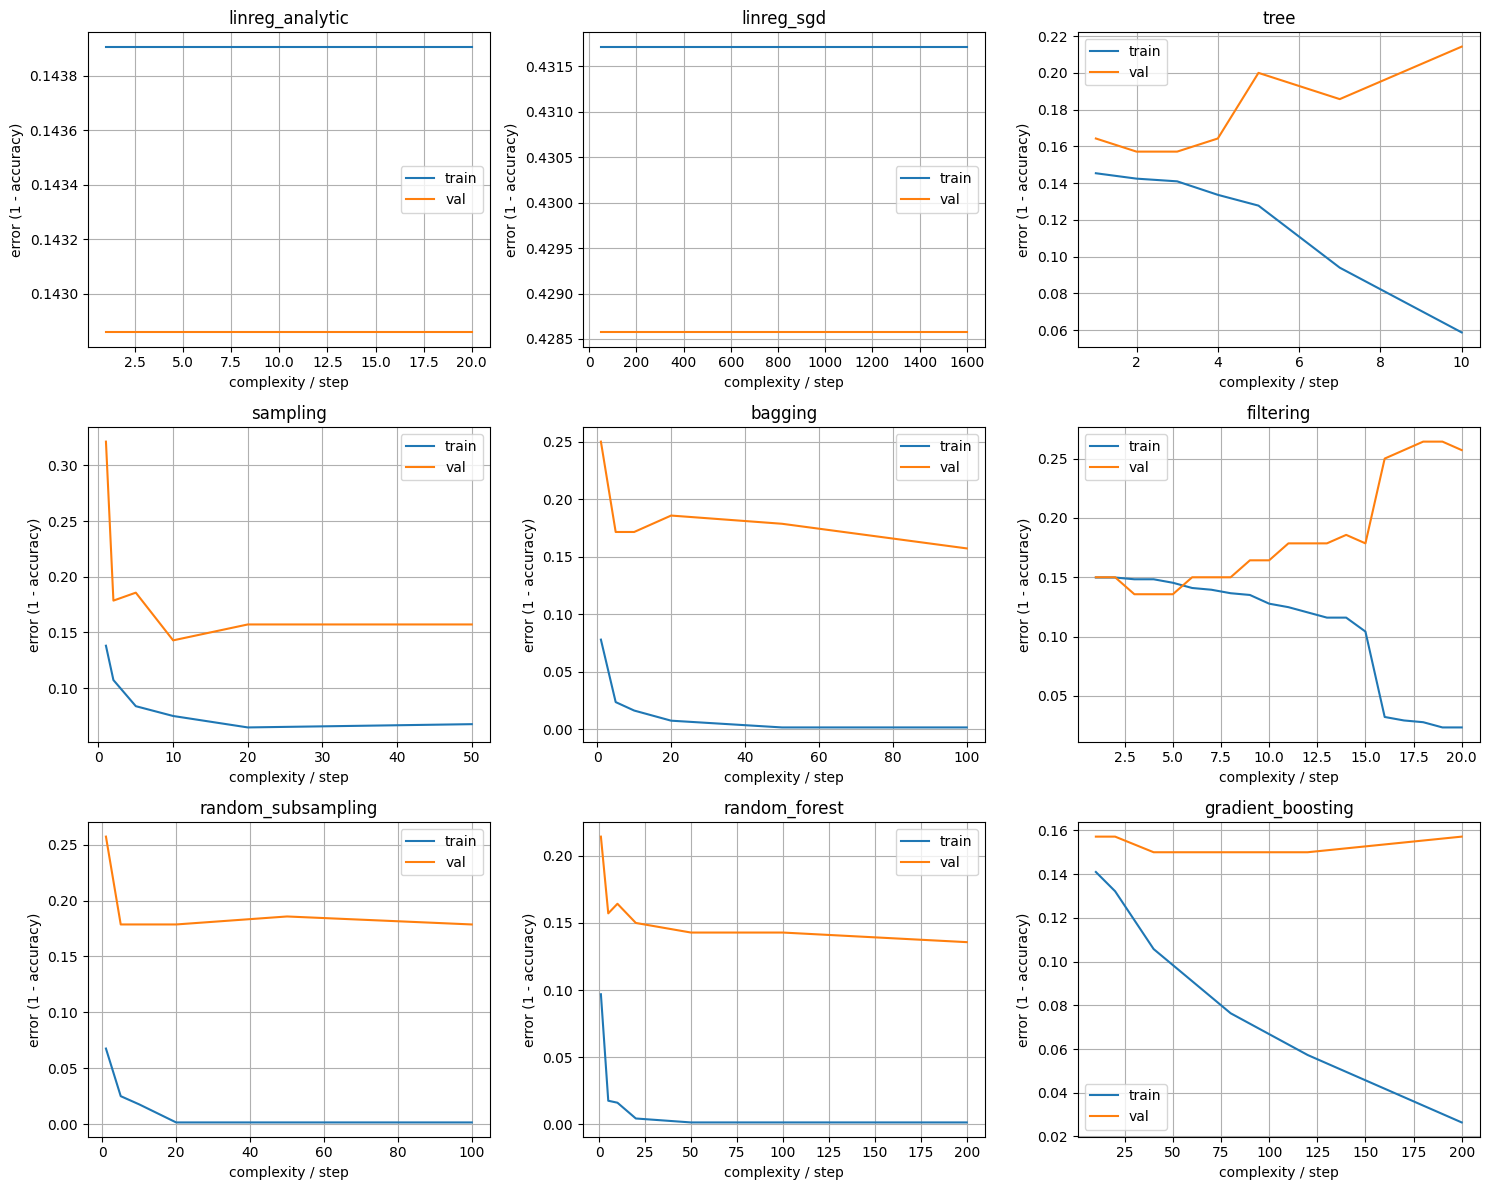

In [9]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score


def eval_path(build_model, kind, steps, X_train, y_train, X_val, y_val):
    train_errs = []
    val_errs = []
    for s in steps:
        model = build_model(s)
        model.fit(X_train, y_train)

        if kind == "reg":
            y_tr = np.where(model.predict(X_train) >= 0.0, 1, -1)
            y_va = np.where(model.predict(X_val) >= 0.0, 1, -1)
        else:
            y_tr = model.predict(X_train)
            y_va = model.predict(X_val)

        train_errs.append(1.0 - accuracy_score(y_train, y_tr))
        val_errs.append(1.0 - accuracy_score(y_val, y_va))

    return np.array(steps), np.array(train_errs), np.array(val_errs)


n_features = X_train.shape[1]

experiments = []

steps_lin = list(range(1, 21))
experiments.append((
    "linreg_analytic",
    "reg",
    steps_lin,
    lambda s: LinearRegression(fit_intercept=False)
))

steps_sgd = [50, 100, 200, 400, 800, 1600]
experiments.append((
    "linreg_sgd",
    "reg",
    steps_sgd,
    lambda it: SGDRegressor(
        loss="squared_error",
        max_iter=int(it),
        tol=1e-3,
        fit_intercept=False,
        random_state=42
    )
))

steps_tree = [1, 2, 3, 4, 5, 7, 10]
experiments.append((
    "tree",
    "clf",
    steps_tree,
    lambda depth: DecisionTreeClassifier(
        max_depth=int(depth),
        random_state=42
    )
))

steps_sampling = [1, 2, 5, 10, 20, 50]
experiments.append((
    "sampling",
    "clf",
    steps_sampling,
    lambda n: BaggingClassifier(
        estimator=DecisionTreeClassifier(random_state=42),
        n_estimators=int(n),
        max_samples=0.5,
        bootstrap=True,
        n_jobs=-1,
        random_state=42
    )
))

steps_bagging = [1, 5, 10, 20, 50, 100]
experiments.append((
    "bagging",
    "clf",
    steps_bagging,
    lambda n: BaggingClassifier(
        estimator=DecisionTreeClassifier(random_state=42),
        n_estimators=int(n),
        bootstrap=True,
        n_jobs=-1,
        random_state=42
    )
))

max_k = max(1, min(20, n_features - 1))
steps_filter = list(range(1, max_k + 1))

def build_filter(k):
    k_eff = min(int(k), n_features - 1)
    return make_pipeline(
        FunctionTransformer(lambda X: X[:, 1:]),
        SelectKBest(f_classif, k=k_eff),
        DecisionTreeClassifier(random_state=42)
    )

experiments.append((
    "filtering",
    "clf",
    steps_filter,
    build_filter
))

steps_rs = [1, 5, 10, 20, 50, 100]
experiments.append((
    "random_subsampling",
    "clf",
    steps_rs,
    lambda n: BaggingClassifier(
        estimator=DecisionTreeClassifier(random_state=42),
        n_estimators=int(n),
        max_samples=0.7,
        bootstrap=False,
        n_jobs=-1,
        random_state=42
    )
))

steps_rf = [1, 5, 10, 20, 50, 100, 200]
experiments.append((
    "random_forest",
    "clf",
    steps_rf,
    lambda n: RandomForestClassifier(
        n_estimators=int(n),
        n_jobs=-1,
        random_state=42
    )
))

steps_gb = [10, 20, 40, 80, 120, 200]
experiments.append((
    "gradient_boosting",
    "clf",
    steps_gb,
    lambda n: GradientBoostingClassifier(
        n_estimators=int(n),
        learning_rate=0.1,
        max_depth=3,
        random_state=42
    )
))

results = []
for name, kind, steps, builder in experiments:
    s, train_err, val_err = eval_path(
        builder, kind, steps, X_train, y_train, X_val, y_val
    )
    results.append((name, s, train_err, val_err))

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.ravel()

for i, (name, steps, train_err, val_err) in enumerate(results):
    ax = axes[i]
    ax.plot(steps, train_err, label="train")
    ax.plot(steps, val_err, label="val")
    ax.set_title(name)
    ax.set_xlabel("complexity / step")
    ax.set_ylabel("error (1 - accuracy)")
    ax.grid(True)
    ax.legend()

for j in range(len(results), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [10]:
import numpy as np
import optuna

from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score


def pred(model, kind, X):
    if kind == "reg":
        return np.where(model.predict(X) >= 0.0, 1, -1)
    return model.predict(X)


def tune_with_optuna(build_model, kind, X_train, y_train, X_val, y_val, n_trials):
    best_model = None
    best_score = -np.inf

    def objective(trial):
        nonlocal best_model, best_score
        model = build_model(trial)
        model.fit(X_train, y_train)
        y_pred_val = pred(model, kind, X_val)
        score = accuracy_score(y_val, y_pred_val)
        if score > best_score:
            best_score = score
            best_model = model
        return score

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials)
    return best_model, study


n_features = X_train.shape[1]
max_k = max(1, min(50, n_features - 1))


def build_linreg_analytic(trial):
    return LinearRegression(fit_intercept=False)


def build_linreg_sgd(trial):
    alpha = trial.suggest_float("alpha", 1e-6, 1e-2, log=True)
    eta0 = trial.suggest_float("eta0", 1e-3, 1.0, log=True)
    max_iter = trial.suggest_int("max_iter", 500, 5000)
    return SGDRegressor(
        loss="squared_error",
        penalty="l2",
        alpha=alpha,
        learning_rate="constant",
        eta0=eta0,
        max_iter=max_iter,
        tol=1e-3,
        fit_intercept=False,
        random_state=42
    )


def build_tree(trial):
    max_depth = trial.suggest_int("max_depth", 1, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 50)
    return DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )


def build_sampling(trial):
    n_estimators = trial.suggest_int("n_estimators", 5, 200)
    max_samples = trial.suggest_float("max_samples", 0.3, 1.0)
    return BaggingClassifier(
        estimator=DecisionTreeClassifier(random_state=42),
        n_estimators=n_estimators,
        max_samples=max_samples,
        bootstrap=True,
        n_jobs=-1,
        random_state=42
    )


def build_bagging(trial):
    n_estimators = trial.suggest_int("n_estimators", 5, 200)
    max_samples = trial.suggest_float("max_samples", 0.5, 1.0)
    return BaggingClassifier(
        estimator=DecisionTreeClassifier(random_state=42),
        n_estimators=n_estimators,
        max_samples=max_samples,
        bootstrap=True,
        n_jobs=-1,
        random_state=42
    )


def build_filtering(trial):
    k = trial.suggest_int("k", 1, max_k)
    max_depth = trial.suggest_int("max_depth", 1, 15)
    return make_pipeline(
        FunctionTransformer(lambda X: X[:, 1:]),
        SelectKBest(f_classif, k=k),
        DecisionTreeClassifier(
            max_depth=max_depth,
            random_state=42
        )
    )


def build_random_subsampling(trial):
    n_estimators = trial.suggest_int("n_estimators", 5, 200)
    max_samples = trial.suggest_float("max_samples", 0.3, 1.0)
    return BaggingClassifier(
        estimator=DecisionTreeClassifier(random_state=42),
        n_estimators=n_estimators,
        max_samples=max_samples,
        bootstrap=False,
        n_jobs=-1,
        random_state=42
    )


def build_random_forest(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 400)
    max_depth = trial.suggest_int("max_depth", 3, 20)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2"])
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 20)
    return RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        max_features=max_features,
        min_samples_leaf=min_samples_leaf,
        n_jobs=-1,
        random_state=42
    )


def build_gradient_boosting(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 300)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3, log=True)
    max_depth = trial.suggest_int("max_depth", 1, 5)
    subsample = trial.suggest_float("subsample", 0.5, 1.0)
    return GradientBoostingClassifier(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        subsample=subsample,
        random_state=42
    )


search_space = [
    ("linreg_analytic", "reg", build_linreg_analytic, 10),
    ("linreg_sgd", "reg", build_linreg_sgd, 30),
    ("tree", "clf", build_tree, 30),
    ("sampling", "clf", build_sampling, 30),
    ("bagging", "clf", build_bagging, 30),
    ("filtering", "clf", build_filtering, 30),
    ("random_subsampling", "clf", build_random_subsampling, 30),
    ("random_forest", "clf", build_random_forest, 40),
    ("gradient_boosting", "clf", build_gradient_boosting, 40),
]

models = {}
studies = {}

for name, kind, builder, n_trials in search_space:
    best_model, study = tune_with_optuna(
        builder, kind, X_train, y_train, X_val, y_val, n_trials=n_trials
    )
    models[name] = (kind, best_model)
    studies[name] = study

for name, (kind, model) in models.items():
    y_pred_train = pred(model, kind, X_train)
    y_pred_val = pred(model, kind, X_val)
    y_pred_test = pred(model, kind, X_test)

    train_acc = accuracy_score(y_train, y_pred_train)
    val_acc = accuracy_score(y_val, y_pred_val)
    test_acc = accuracy_score(y_test, y_pred_test)

    print(
        f"{name}: "
        f"train={train_acc:.4f}, "
        f"val={val_acc:.4f}, "
        f"test={test_acc:.4f}"
    )


c:\Users\zaits\VScodeProjects\PythonKernel\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-11-26 12:39:39,895] A new study created in memory with name: no-name-38db7764-1f3b-47d8-af46-e3a3523667cd
[I 2025-11-26 12:39:39,906] Trial 0 finished with value: 0.8571428571428571 and parameters: {}. Best is trial 0 with value: 0.8571428571428571.
[I 2025-11-26 12:39:39,919] Trial 1 finished with value: 0.8571428571428571 and parameters: {}. Best is trial 0 with value: 0.8571428571428571.
[I 2025-11-26 12:39:39,940] Trial 2 finished with value: 0.8571428571428571 and parameters: {}. Best is trial 0 with value: 0.8571428571428571.
[I 2025-11-26 12:39:39,950] Trial 3 finished with value: 0.8571428571428571 and parameters: {}. Best is trial 0 with value: 0.8571428571428571.
[I 2025-11-26 12:39:39,961] Trial 4 fi

linreg_analytic: train=0.8561, val=0.8571, test=0.8621
linreg_sgd: train=0.5830, val=0.6000, test=0.6759
tree: train=0.8502, val=0.8500, test=0.8483
sampling: train=0.9134, val=0.8571, test=0.8414
bagging: train=0.9457, val=0.8571, test=0.8621
filtering: train=0.8664, val=0.8714, test=0.8483
random_subsampling: train=0.9501, val=0.8643, test=0.8345
random_forest: train=0.9178, val=0.8571, test=0.8552
gradient_boosting: train=0.9809, val=0.8643, test=0.8552


In [11]:
import numpy as np

for name, (kind, model) in models.items():
    y_pred_val = pred(model, kind, X_val)
    unique, counts = np.unique(y_pred_val, return_counts=True)
    print(name, dict(zip(unique, counts)))


linreg_analytic {np.int64(-1): np.int64(135), np.int64(1): np.int64(5)}
linreg_sgd {np.int64(-1): np.int64(89), np.int64(1): np.int64(51)}
tree {np.int64(-1): np.int64(140)}
sampling {np.int64(-1): np.int64(137), np.int64(1): np.int64(3)}
bagging {np.int64(-1): np.int64(135), np.int64(1): np.int64(5)}
filtering {np.int64(-1): np.int64(131), np.int64(1): np.int64(9)}
random_subsampling {np.int64(-1): np.int64(138), np.int64(1): np.int64(2)}
random_forest {np.int64(-1): np.int64(139), np.int64(1): np.int64(1)}
gradient_boosting {np.int64(-1): np.int64(134), np.int64(1): np.int64(6)}


In [12]:
from sklearn.metrics import precision_score, recall_score, f1_score

for name, (kind, model) in models.items():
    y_pred_val = pred(model, kind, X_val)
    print(
        name,
        "acc=", accuracy_score(y_val, y_pred_val),
        "f1=", f1_score(y_val, y_pred_val, pos_label=1),
        "recall=", recall_score(y_val, y_pred_val, pos_label=1),
    )


linreg_analytic acc= 0.8571428571428571 f1= 0.23076923076923078 recall= 0.14285714285714285
linreg_sgd acc= 0.6 f1= 0.2222222222222222 recall= 0.38095238095238093
tree acc= 0.85 f1= 0.0 recall= 0.0
sampling acc= 0.8571428571428571 f1= 0.16666666666666666 recall= 0.09523809523809523
bagging acc= 0.8571428571428571 f1= 0.23076923076923078 recall= 0.14285714285714285
filtering acc= 0.8714285714285714 f1= 0.4 recall= 0.2857142857142857
random_subsampling acc= 0.8642857142857143 f1= 0.17391304347826086 recall= 0.09523809523809523
random_forest acc= 0.8571428571428571 f1= 0.09090909090909091 recall= 0.047619047619047616
gradient_boosting acc= 0.8642857142857143 f1= 0.2962962962962963 recall= 0.19047619047619047


In [13]:
from sklearn.metrics import f1_score

probs = models["gradient_boosting"][1].predict_proba(X_val)[:, 1]

best_t, best_f1 = None, -1
for t in np.linspace(0.05, 0.95, 19):
    y_pred_t = np.where(probs >= t, 1, -1)
    f1 = f1_score(y_val, y_pred_t, pos_label=1)
    if f1 > best_f1:
        best_f1, best_t = f1, t

print("best threshold:", best_t, "best f1:", best_f1)


best threshold: 0.15 best f1: 0.4827586206896552


In [14]:
import numpy as np
import optuna

from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, f1_score, recall_score


def pred(model, kind, X):
    if kind == "reg":
        return np.where(model.predict(X) >= 0.0, 1, -1)
    return model.predict(X)


def tune_with_optuna(build_model, kind, X_train, y_train, X_val, y_val, n_trials):
    best_model = None
    best_score = -np.inf

    def objective(trial):
        nonlocal best_model, best_score
        model = build_model(trial)
        model.fit(X_train, y_train)
        y_pred_val = pred(model, kind, X_val)
        score = f1_score(y_val, y_pred_val, pos_label=1)
        if score > best_score:
            best_score = score
            best_model = model
        return score

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials)
    return best_model, study


n_features = X_train.shape[1]
max_k = max(1, min(50, n_features - 1))


def build_linreg_analytic(trial):
    return LinearRegression(fit_intercept=False)


def build_linreg_sgd(trial):
    alpha = trial.suggest_float("alpha", 1e-6, 1e-2, log=True)
    eta0 = trial.suggest_float("eta0", 1e-3, 1.0, log=True)
    max_iter = trial.suggest_int("max_iter", 500, 5000)
    return SGDRegressor(
        loss="squared_error",
        penalty="l2",
        alpha=alpha,
        learning_rate="constant",
        eta0=eta0,
        max_iter=max_iter,
        tol=1e-3,
        fit_intercept=False,
        random_state=42
    )


def build_tree(trial):
    max_depth = trial.suggest_int("max_depth", 1, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 50)
    return DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        class_weight="balanced",
        random_state=42
    )


def build_sampling(trial):
    n_estimators = trial.suggest_int("n_estimators", 5, 200)
    max_samples = trial.suggest_float("max_samples", 0.3, 1.0)
    base = DecisionTreeClassifier(class_weight="balanced", random_state=42)
    return BaggingClassifier(
        estimator=base,
        n_estimators=n_estimators,
        max_samples=max_samples,
        bootstrap=True,
        n_jobs=-1,
        random_state=42
    )


def build_bagging(trial):
    n_estimators = trial.suggest_int("n_estimators", 5, 200)
    max_samples = trial.suggest_float("max_samples", 0.5, 1.0)
    base = DecisionTreeClassifier(class_weight="balanced", random_state=42)
    return BaggingClassifier(
        estimator=base,
        n_estimators=n_estimators,
        max_samples=max_samples,
        bootstrap=True,
        n_jobs=-1,
        random_state=42
    )


def build_filtering(trial):
    k = trial.suggest_int("k", 1, max_k)
    max_depth = trial.suggest_int("max_depth", 1, 15)
    return make_pipeline(
        FunctionTransformer(lambda X: X[:, 1:]),
        SelectKBest(f_classif, k=k),
        DecisionTreeClassifier(
            max_depth=max_depth,
            class_weight="balanced",
            random_state=42
        )
    )


def build_random_subsampling(trial):
    n_estimators = trial.suggest_int("n_estimators", 5, 200)
    max_samples = trial.suggest_float("max_samples", 0.3, 1.0)
    base = DecisionTreeClassifier(class_weight="balanced", random_state=42)
    return BaggingClassifier(
        estimator=base,
        n_estimators=n_estimators,
        max_samples=max_samples,
        bootstrap=False,
        n_jobs=-1,
        random_state=42
    )


def build_random_forest(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 400)
    max_depth = trial.suggest_int("max_depth", 3, 20)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2"])
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 20)
    return RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        max_features=max_features,
        min_samples_leaf=min_samples_leaf,
        class_weight="balanced",
        n_jobs=-1,
        random_state=42
    )


def build_gradient_boosting(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 300)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3, log=True)
    max_depth = trial.suggest_int("max_depth", 1, 5)
    subsample = trial.suggest_float("subsample", 0.5, 1.0)
    return GradientBoostingClassifier(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        subsample=subsample,
        random_state=42
    )


search_space = [
    ("linreg_analytic", "reg", build_linreg_analytic, 10),
    ("linreg_sgd", "reg", build_linreg_sgd, 30),
    ("tree", "clf", build_tree, 30),
    ("sampling", "clf", build_sampling, 30),
    ("bagging", "clf", build_bagging, 30),
    ("filtering", "clf", build_filtering, 30),
    ("random_subsampling", "clf", build_random_subsampling, 30),
    ("random_forest", "clf", build_random_forest, 40),
    ("gradient_boosting", "clf", build_gradient_boosting, 40),
]

models = {}
studies = {}

for name, kind, builder, n_trials in search_space:
    best_model, study = tune_with_optuna(
        builder, kind, X_train, y_train, X_val, y_val, n_trials=n_trials
    )
    models[name] = (kind, best_model)
    studies[name] = study

for name, (kind, model) in models.items():
    y_pred_train = pred(model, kind, X_train)
    y_pred_val = pred(model, kind, X_val)
    y_pred_test = pred(model, kind, X_test)

    train_acc = accuracy_score(y_train, y_pred_train)
    val_acc = accuracy_score(y_val, y_pred_val)
    test_acc = accuracy_score(y_test, y_pred_test)

    val_f1 = f1_score(y_val, y_pred_val, pos_label=1)
    val_rec = recall_score(y_val, y_pred_val, pos_label=1)

    print(
        f"{name}: "
        f"train_acc={train_acc:.4f}, "
        f"val_acc={val_acc:.4f}, "
        f"test_acc={test_acc:.4f}, "
        f"val_f1={val_f1:.4f}, "
        f"val_recall={val_rec:.4f}"
    )


[I 2025-11-26 12:48:02,422] A new study created in memory with name: no-name-971aeeb4-d8da-4f9e-8b50-0a265d777f52
[I 2025-11-26 12:48:02,438] Trial 0 finished with value: 0.23076923076923078 and parameters: {}. Best is trial 0 with value: 0.23076923076923078.
[I 2025-11-26 12:48:02,450] Trial 1 finished with value: 0.23076923076923078 and parameters: {}. Best is trial 0 with value: 0.23076923076923078.
[I 2025-11-26 12:48:02,461] Trial 2 finished with value: 0.23076923076923078 and parameters: {}. Best is trial 0 with value: 0.23076923076923078.
[I 2025-11-26 12:48:02,474] Trial 3 finished with value: 0.23076923076923078 and parameters: {}. Best is trial 0 with value: 0.23076923076923078.
[I 2025-11-26 12:48:02,485] Trial 4 finished with value: 0.23076923076923078 and parameters: {}. Best is trial 0 with value: 0.23076923076923078.
[I 2025-11-26 12:48:02,495] Trial 5 finished with value: 0.23076923076923078 and parameters: {}. Best is trial 0 with value: 0.23076923076923078.
[I 2025-11

linreg_analytic: train_acc=0.8561, val_acc=0.8571, test_acc=0.8621, val_f1=0.2308, val_recall=0.1429
linreg_sgd: train_acc=0.5316, val_acc=0.5357, test_acc=0.4138, val_f1=0.2857, val_recall=0.6190
tree: train_acc=0.6828, val_acc=0.6286, test_acc=0.6138, val_f1=0.3500, val_recall=0.6667
sampling: train_acc=0.9985, val_acc=0.8714, test_acc=0.8552, val_f1=0.2500, val_recall=0.1429
bagging: train_acc=0.9985, val_acc=0.8714, test_acc=0.8552, val_f1=0.2500, val_recall=0.1429
filtering: train_acc=0.8003, val_acc=0.8000, test_acc=0.7931, val_f1=0.4167, val_recall=0.4762
random_subsampling: train_acc=0.9883, val_acc=0.8714, test_acc=0.8552, val_f1=0.3571, val_recall=0.2381
random_forest: train_acc=0.8429, val_acc=0.7500, test_acc=0.7724, val_f1=0.4068, val_recall=0.5714
gradient_boosting: train_acc=0.9956, val_acc=0.8500, test_acc=0.8276, val_f1=0.4000, val_recall=0.3333


In [15]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

def get_scores(model, kind, X):
    if kind == "reg":
        return model.predict(X)
    if hasattr(model, "predict_proba"):
        return model.predict_proba(X)[:, 1]
    if hasattr(model, "decision_function"):
        s = model.decision_function(X)
        if s.ndim == 1:
            return s
        return s[:, 1]
    y = model.predict(X)
    return np.where(y == 1, 1.0, -1.0)


def pred_with_threshold(model, kind, X, thr):
    s = get_scores(model, kind, X)
    return np.where(s >= thr, 1, -1)


desired_pos_frac = 0.15
thresholds = {}

for name, (kind, model) in models.items():
    s_val = get_scores(model, kind, X_val)
    n = len(s_val)
    k = max(1, int(round(desired_pos_frac * n)))
    thr = np.sort(s_val)[::-1][k - 1]
    thresholds[name] = thr

    y_val_pred = np.where(s_val >= thr, 1, -1)
    frac_pos = (y_val_pred == 1).mean()
    print(f"{name}: thr={thr:.4f}, val_pos_frac={frac_pos:.3f}")


print("\n=== metrics with top-15% threshold on val ===")
for name, (kind, model) in models.items():
    thr = thresholds[name]

    y_tr = pred_with_threshold(model, kind, X_train, thr)
    y_va = pred_with_threshold(model, kind, X_val, thr)
    y_te = pred_with_threshold(model, kind, X_test, thr)

    train_acc = accuracy_score(y_train, y_tr)
    val_acc = accuracy_score(y_val, y_va)
    test_acc = accuracy_score(y_test, y_te)

    val_f1 = f1_score(y_val, y_va, pos_label=1)
    val_rec = recall_score(y_val, y_va, pos_label=1)
    val_prec = precision_score(y_val, y_va, pos_label=1)

    print(
        f"{name}: "
        f"train_acc={train_acc:.4f}, "
        f"val_acc={val_acc:.4f}, "
        f"test_acc={test_acc:.4f}, "
        f"val_f1={val_f1:.4f}, "
        f"val_recall={val_rec:.4f}, "
        f"val_prec={val_prec:.4f}"
    )


linreg_analytic: thr=-0.3476, val_pos_frac=0.150
linreg_sgd: thr=13812453848255.4688, val_pos_frac=0.150
tree: thr=0.7469, val_pos_frac=0.164
sampling: thr=0.3314, val_pos_frac=0.157
bagging: thr=0.3455, val_pos_frac=0.150
filtering: thr=0.6138, val_pos_frac=0.193
random_subsampling: thr=0.3333, val_pos_frac=0.200
random_forest: thr=0.5476, val_pos_frac=0.150
gradient_boosting: thr=0.2663, val_pos_frac=0.150

=== metrics with top-15% threshold on val ===
linreg_analytic: train_acc=0.8517, val_acc=0.8286, test_acc=0.8483, val_f1=0.4286, val_recall=0.4286, val_prec=0.4286
linreg_sgd: train_acc=0.7577, val_acc=0.8000, test_acc=0.7586, val_f1=0.3333, val_recall=0.3333, val_prec=0.3333
tree: train_acc=0.8164, val_acc=0.7571, test_acc=0.8000, val_f1=0.2273, val_recall=0.2381, val_prec=0.2174
sampling: train_acc=0.9971, val_acc=0.7929, test_acc=0.7793, val_f1=0.3256, val_recall=0.3333, val_prec=0.3182
bagging: train_acc=0.9985, val_acc=0.7857, test_acc=0.8207, val_f1=0.2857, val_recall=0.2857

In [23]:
import numpy as np
import optuna

from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score


def get_scores(model, kind, X):
    if kind == "reg":
        return model.predict(X)
    if hasattr(model, "predict_proba"):
        return model.predict_proba(X)[:, 1]
    if hasattr(model, "decision_function"):
        s = model.decision_function(X)
        if s.ndim == 1:
            return s
        return s[:, 1]
    y = model.predict(X)
    return np.where(y == 1, 1.0, -1.0)


def compute_threshold_for_top_frac(scores, frac):
    scores = np.asarray(scores)
    n = len(scores)
    k = max(1, int(round(frac * n)))
    sorted_scores = np.sort(scores)[::-1]
    thr = sorted_scores[k - 1]
    return thr


def pred_with_threshold(model, kind, X, thr):
    s = get_scores(model, kind, X)
    return np.where(s >= thr, 1, -1)


def tune_with_optuna(build_model, kind, X_train, y_train, X_val, y_val, n_trials, desired_pos_frac):
    best_model = None
    best_thr = None
    best_score = -np.inf

    def objective(trial):
        nonlocal best_model, best_thr, best_score
        model = build_model(trial)
        model.fit(X_train, y_train)

        s_val = get_scores(model, kind, X_val)
        thr = compute_threshold_for_top_frac(s_val, desired_pos_frac)
        y_val_pred = np.where(s_val >= thr, 1, -1)

        score = f1_score(y_val, y_val_pred, pos_label=1)

        if score > best_score:
            best_score = score
            best_model = model
            best_thr = thr

        return score

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials)
    return best_model, best_thr, study


desired_pos_frac = 0.15
n_features = X_train.shape[1]
max_k = max(1, min(50, n_features - 1))


def build_linreg_analytic(trial):
    return LinearRegression(fit_intercept=False)


def build_linreg_sgd(trial):
    alpha = trial.suggest_float("alpha", 1e-6, 1e-2, log=True)
    eta0 = trial.suggest_float("eta0", 1e-3, 1.0, log=True)
    max_iter = trial.suggest_int("max_iter", 500, 5000)
    return SGDRegressor(
        loss="squared_error",
        penalty="l2",
        alpha=alpha,
        learning_rate="constant",
        eta0=eta0,
        max_iter=max_iter,
        tol=1e-3,
        fit_intercept=False,
        random_state=42
    )


def build_tree(trial):
    max_depth = trial.suggest_int("max_depth", 1, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 50)
    return DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        class_weight="balanced",
        random_state=42
    )


def build_sampling(trial):
    n_estimators = trial.suggest_int("n_estimators", 5, 200)
    max_samples = trial.suggest_float("max_samples", 0.3, 1.0)
    base = DecisionTreeClassifier(class_weight="balanced", random_state=42)
    return BaggingClassifier(
        estimator=base,
        n_estimators=n_estimators,
        max_samples=max_samples,
        bootstrap=True,
        n_jobs=-1,
        random_state=42
    )


def build_bagging(trial):
    n_estimators = trial.suggest_int("n_estimators", 5, 200)
    max_samples = trial.suggest_float("max_samples", 0.5, 1.0)
    base = DecisionTreeClassifier(class_weight="balanced", random_state=42)
    return BaggingClassifier(
        estimator=base,
        n_estimators=n_estimators,
        max_samples=max_samples,
        bootstrap=True,
        n_jobs=-1,
        random_state=42
    )


def build_filtering(trial):
    k = trial.suggest_int("k", 1, max_k)
    max_depth = trial.suggest_int("max_depth", 1, 15)
    return make_pipeline(
        FunctionTransformer(lambda X: X[:, 1:]),
        SelectKBest(f_classif, k=k),
        DecisionTreeClassifier(
            max_depth=max_depth,
            class_weight="balanced",
            random_state=42
        )
    )


def build_random_subsampling(trial):
    n_estimators = trial.suggest_int("n_estimators", 5, 200)
    max_samples = trial.suggest_float("max_samples", 0.3, 1.0)
    base = DecisionTreeClassifier(class_weight="balanced", random_state=42)
    return BaggingClassifier(
        estimator=base,
        n_estimators=n_estimators,
        max_samples=max_samples,
        bootstrap=False,
        n_jobs=-1,
        random_state=42
    )


def build_random_forest(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 400)
    max_depth = trial.suggest_int("max_depth", 3, 20)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2"])
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 20)
    return RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        max_features=max_features,
        min_samples_leaf=min_samples_leaf,
        class_weight="balanced",
        n_jobs=-1,
        random_state=42
    )


def build_gradient_boosting(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 300)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3, log=True)
    max_depth = trial.suggest_int("max_depth", 1, 5)
    subsample = trial.suggest_float("subsample", 0.5, 1.0)
    return GradientBoostingClassifier(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        subsample=subsample,
        random_state=42
    )


search_space = [
    ("linreg_analytic", "reg", build_linreg_analytic, 5),
    ("linreg_sgd", "reg", build_linreg_sgd, 30),
    ("tree", "clf", build_tree, 30),
    ("sampling", "clf", build_sampling, 30),
    ("bagging", "clf", build_bagging, 30),
    ("filtering", "clf", build_filtering, 30),
    ("random_subsampling", "clf", build_random_subsampling, 30),
    ("random_forest", "clf", build_random_forest, 40),
    ("gradient_boosting", "clf", build_gradient_boosting, 40),
]

models = {}      # name -> (kind, model, thr)
studies = {}     # name -> optuna study

for name, kind, builder, n_trials in search_space:
    best_model, best_thr, study = tune_with_optuna(
        builder,
        kind,
        X_train,
        y_train,
        X_val,
        y_val,
        n_trials=n_trials,
        desired_pos_frac=desired_pos_frac
    )
    models[name] = (kind, best_model, best_thr)
    studies[name] = study
    print(f"{name}: best_val_f1={study.best_value:.4f}, best_thr={best_thr:.4f}")


print("\n=== final metrics with top-15% thresholds (picked inside Optuna) ===")
for name, (kind, model, thr) in models.items():
    y_tr = pred_with_threshold(model, kind, X_train, thr)
    y_va = pred_with_threshold(model, kind, X_val, thr)
    y_te = pred_with_threshold(model, kind, X_test, thr)

    train_acc = accuracy_score(y_train, y_tr)
    val_acc = accuracy_score(y_val, y_va)
    test_acc = accuracy_score(y_test, y_te)

    val_f1 = f1_score(y_val, y_va, pos_label=1)
    val_rec = recall_score(y_val, y_va, pos_label=1)
    val_prec = precision_score(y_val, y_va, pos_label=1)

    val_pos_frac = (y_va == 1).mean()

    print(
        f"{name}: "
        f"train_acc={train_acc:.4f}, "
        f"val_acc={val_acc:.4f}, "
        f"test_acc={test_acc:.4f}, "
        f"val_f1={val_f1:.4f}, "
        f"val_recall={val_rec:.4f}, "
        f"val_prec={val_prec:.4f}, "
        f"val_pos_frac={val_pos_frac:.3f}"
    )


[I 2025-11-26 13:59:09,507] A new study created in memory with name: no-name-83941e54-f195-4b13-89b3-e0bc6cdd8ab4
[I 2025-11-26 13:59:09,522] Trial 0 finished with value: 0.42857142857142855 and parameters: {}. Best is trial 0 with value: 0.42857142857142855.
[I 2025-11-26 13:59:09,532] Trial 1 finished with value: 0.42857142857142855 and parameters: {}. Best is trial 0 with value: 0.42857142857142855.
[I 2025-11-26 13:59:09,546] Trial 2 finished with value: 0.42857142857142855 and parameters: {}. Best is trial 0 with value: 0.42857142857142855.
[I 2025-11-26 13:59:09,561] Trial 3 finished with value: 0.42857142857142855 and parameters: {}. Best is trial 0 with value: 0.42857142857142855.


[I 2025-11-26 13:59:09,573] Trial 4 finished with value: 0.42857142857142855 and parameters: {}. Best is trial 0 with value: 0.42857142857142855.
[I 2025-11-26 13:59:09,575] A new study created in memory with name: no-name-2a15cbab-dd47-434d-9cb5-306ea8e32cfc
[I 2025-11-26 13:59:09,586] Trial 0 finished with value: 0.047619047619047616 and parameters: {'alpha': 0.002458147773490538, 'eta0': 0.004114421695375687, 'max_iter': 2240}. Best is trial 0 with value: 0.047619047619047616.
[I 2025-11-26 13:59:09,596] Trial 1 finished with value: 0.047619047619047616 and parameters: {'alpha': 0.0018633361985429633, 'eta0': 0.007946379269951636, 'max_iter': 2578}. Best is trial 0 with value: 0.047619047619047616.
[I 2025-11-26 13:59:09,602] Trial 2 finished with value: 0.3333333333333333 and parameters: {'alpha': 0.0009794489954301105, 'eta0': 0.031481801913436934, 'max_iter': 866}. Best is trial 2 with value: 0.3333333333333333.
[I 2025-11-26 13:59:09,613] Trial 3 finished with value: 0.333333333

linreg_analytic: best_val_f1=0.4286, best_thr=-0.3476


[I 2025-11-26 13:59:09,771] Trial 13 finished with value: 0.0 and parameters: {'alpha': 1.0649145771928722e-06, 'eta0': 0.5604947196415779, 'max_iter': 1374}. Best is trial 2 with value: 0.3333333333333333.
[I 2025-11-26 13:59:09,783] Trial 14 finished with value: 0.3333333333333333 and parameters: {'alpha': 0.004422022981375263, 'eta0': 0.04479531104610624, 'max_iter': 4912}. Best is trial 2 with value: 0.3333333333333333.
[I 2025-11-26 13:59:09,801] Trial 15 finished with value: 0.0 and parameters: {'alpha': 5.860955597748558e-05, 'eta0': 0.26034405000377636, 'max_iter': 1823}. Best is trial 2 with value: 0.3333333333333333.
[I 2025-11-26 13:59:09,818] Trial 16 finished with value: 0.0 and parameters: {'alpha': 0.0010660219401888063, 'eta0': 0.0977742470929625, 'max_iter': 987}. Best is trial 2 with value: 0.3333333333333333.
[I 2025-11-26 13:59:09,832] Trial 17 finished with value: 0.3333333333333333 and parameters: {'alpha': 0.008772934214076777, 'eta0': 0.027472510644656264, 'max_

linreg_sgd: best_val_f1=0.3333, best_thr=14014346404517.5312


[I 2025-11-26 13:59:10,241] Trial 17 finished with value: 0.19230769230769232 and parameters: {'max_depth': 7, 'min_samples_leaf': 30}. Best is trial 15 with value: 0.30434782608695654.
[I 2025-11-26 13:59:10,257] Trial 18 finished with value: 0.3010752688172043 and parameters: {'max_depth': 4, 'min_samples_leaf': 20}. Best is trial 15 with value: 0.30434782608695654.
[I 2025-11-26 13:59:10,273] Trial 19 finished with value: 0.3181818181818182 and parameters: {'max_depth': 11, 'min_samples_leaf': 20}. Best is trial 19 with value: 0.3181818181818182.
[I 2025-11-26 13:59:10,289] Trial 20 finished with value: 0.2222222222222222 and parameters: {'max_depth': 11, 'min_samples_leaf': 11}. Best is trial 19 with value: 0.3181818181818182.
[I 2025-11-26 13:59:10,300] Trial 21 finished with value: 0.25 and parameters: {'max_depth': 6, 'min_samples_leaf': 19}. Best is trial 19 with value: 0.3181818181818182.
[I 2025-11-26 13:59:10,321] Trial 22 finished with value: 0.23076923076923078 and paramet

tree: best_val_f1=0.3182, best_thr=0.7395


[I 2025-11-26 13:59:10,696] Trial 0 finished with value: 0.3333333333333333 and parameters: {'n_estimators': 99, 'max_samples': 0.510483583375424}. Best is trial 0 with value: 0.3333333333333333.
[I 2025-11-26 13:59:10,963] Trial 1 finished with value: 0.32558139534883723 and parameters: {'n_estimators': 78, 'max_samples': 0.9131399664376116}. Best is trial 0 with value: 0.3333333333333333.
[I 2025-11-26 13:59:11,235] Trial 2 finished with value: 0.37209302325581395 and parameters: {'n_estimators': 146, 'max_samples': 0.520261717551609}. Best is trial 2 with value: 0.37209302325581395.
[I 2025-11-26 13:59:11,338] Trial 3 finished with value: 0.35555555555555557 and parameters: {'n_estimators': 30, 'max_samples': 0.6736321531003722}. Best is trial 2 with value: 0.37209302325581395.
[I 2025-11-26 13:59:11,409] Trial 4 finished with value: 0.3181818181818182 and parameters: {'n_estimators': 13, 'max_samples': 0.6074504028525841}. Best is trial 2 with value: 0.37209302325581395.
[I 2025-11

sampling: best_val_f1=0.4762, best_thr=0.3261


[I 2025-11-26 13:59:20,194] Trial 1 finished with value: 0.38095238095238093 and parameters: {'n_estimators': 82, 'max_samples': 0.7454414498078645}. Best is trial 1 with value: 0.38095238095238093.
[I 2025-11-26 13:59:20,784] Trial 2 finished with value: 0.38095238095238093 and parameters: {'n_estimators': 127, 'max_samples': 0.7925165610096624}. Best is trial 1 with value: 0.38095238095238093.
[I 2025-11-26 13:59:21,089] Trial 3 finished with value: 0.3333333333333333 and parameters: {'n_estimators': 52, 'max_samples': 0.9278524692724197}. Best is trial 1 with value: 0.38095238095238093.
[I 2025-11-26 13:59:21,511] Trial 4 finished with value: 0.2916666666666667 and parameters: {'n_estimators': 83, 'max_samples': 0.8144891004236801}. Best is trial 1 with value: 0.38095238095238093.
[I 2025-11-26 13:59:21,724] Trial 5 finished with value: 0.3333333333333333 and parameters: {'n_estimators': 27, 'max_samples': 0.8032065345641484}. Best is trial 1 with value: 0.38095238095238093.
[I 2025

bagging: best_val_f1=0.4186, best_thr=0.3596


[I 2025-11-26 13:59:36,084] Trial 6 finished with value: 0.2777777777777778 and parameters: {'k': 36, 'max_depth': 11}. Best is trial 2 with value: 0.3404255319148936.
[I 2025-11-26 13:59:36,138] Trial 7 finished with value: 0.2727272727272727 and parameters: {'k': 42, 'max_depth': 15}. Best is trial 2 with value: 0.3404255319148936.
[I 2025-11-26 13:59:36,172] Trial 8 finished with value: 0.23255813953488372 and parameters: {'k': 29, 'max_depth': 14}. Best is trial 2 with value: 0.3404255319148936.
[I 2025-11-26 13:59:36,199] Trial 9 finished with value: 0.43478260869565216 and parameters: {'k': 14, 'max_depth': 15}. Best is trial 9 with value: 0.43478260869565216.
[I 2025-11-26 13:59:36,241] Trial 10 finished with value: 0.2857142857142857 and parameters: {'k': 17, 'max_depth': 12}. Best is trial 9 with value: 0.43478260869565216.
[I 2025-11-26 13:59:36,277] Trial 11 finished with value: 0.3333333333333333 and parameters: {'k': 15, 'max_depth': 11}. Best is trial 9 with value: 0.4347

filtering: best_val_f1=0.4348, best_thr=0.7395


[I 2025-11-26 13:59:37,668] Trial 0 finished with value: 0.3181818181818182 and parameters: {'n_estimators': 175, 'max_samples': 0.32481890311167994}. Best is trial 0 with value: 0.3181818181818182.
[I 2025-11-26 13:59:38,088] Trial 1 finished with value: 0.36 and parameters: {'n_estimators': 76, 'max_samples': 0.5911720619147671}. Best is trial 1 with value: 0.36.
[I 2025-11-26 13:59:38,559] Trial 2 finished with value: 0.3111111111111111 and parameters: {'n_estimators': 108, 'max_samples': 0.38597462756969775}. Best is trial 1 with value: 0.36.
[I 2025-11-26 13:59:39,162] Trial 3 finished with value: 0.3333333333333333 and parameters: {'n_estimators': 138, 'max_samples': 0.38302764255912475}. Best is trial 1 with value: 0.36.
[I 2025-11-26 13:59:39,744] Trial 4 finished with value: 0.27906976744186046 and parameters: {'n_estimators': 120, 'max_samples': 0.5310327093007884}. Best is trial 1 with value: 0.36.
[I 2025-11-26 13:59:40,385] Trial 5 finished with value: 0.32558139534883723 

random_subsampling: best_val_f1=0.3810, best_thr=0.3098


[I 2025-11-26 13:59:55,613] Trial 0 finished with value: 0.38095238095238093 and parameters: {'n_estimators': 253, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 12}. Best is trial 0 with value: 0.38095238095238093.
[I 2025-11-26 13:59:57,738] Trial 1 finished with value: 0.42857142857142855 and parameters: {'n_estimators': 347, 'max_depth': 6, 'max_features': 'log2', 'min_samples_leaf': 13}. Best is trial 1 with value: 0.42857142857142855.
[I 2025-11-26 13:59:59,870] Trial 2 finished with value: 0.2857142857142857 and parameters: {'n_estimators': 313, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 18}. Best is trial 1 with value: 0.42857142857142855.
[I 2025-11-26 14:00:00,402] Trial 3 finished with value: 0.3333333333333333 and parameters: {'n_estimators': 78, 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 18}. Best is trial 1 with value: 0.42857142857142855.
[I 2025-11-26 14:00:02,687] Trial 4 finished with value: 0.38095238095238093 and param

random_forest: best_val_f1=0.4762, best_thr=0.5481


[I 2025-11-26 14:00:46,532] Trial 0 finished with value: 0.38095238095238093 and parameters: {'n_estimators': 264, 'learning_rate': 0.08930175304807669, 'max_depth': 3, 'subsample': 0.5871789194763708}. Best is trial 0 with value: 0.38095238095238093.
[I 2025-11-26 14:00:48,379] Trial 1 finished with value: 0.3333333333333333 and parameters: {'n_estimators': 184, 'learning_rate': 0.07055500955059694, 'max_depth': 4, 'subsample': 0.79379703010887}. Best is trial 0 with value: 0.38095238095238093.
[I 2025-11-26 14:00:50,019] Trial 2 finished with value: 0.23809523809523808 and parameters: {'n_estimators': 132, 'learning_rate': 0.11353105428861884, 'max_depth': 5, 'subsample': 0.799406308335983}. Best is trial 0 with value: 0.38095238095238093.
[I 2025-11-26 14:00:52,137] Trial 3 finished with value: 0.2857142857142857 and parameters: {'n_estimators': 240, 'learning_rate': 0.025244737997575033, 'max_depth': 3, 'subsample': 0.9811365122006492}. Best is trial 0 with value: 0.380952380952380

gradient_boosting: best_val_f1=0.4286, best_thr=0.2912

=== final metrics with top-15% thresholds (picked inside Optuna) ===
linreg_analytic: train_acc=0.8517, val_acc=0.8286, test_acc=0.8483, val_f1=0.4286, val_recall=0.4286, val_prec=0.4286, val_pos_frac=0.150
linreg_sgd: train_acc=0.7577, val_acc=0.8000, test_acc=0.7586, val_f1=0.3333, val_recall=0.3333, val_prec=0.3333, val_pos_frac=0.150
tree: train_acc=0.8209, val_acc=0.7857, test_acc=0.7793, val_f1=0.3182, val_recall=0.3333, val_prec=0.3043, val_pos_frac=0.164
sampling: train_acc=0.9838, val_acc=0.8429, test_acc=0.8138, val_f1=0.4762, val_recall=0.4762, val_prec=0.4762, val_pos_frac=0.150
bagging: train_acc=0.9971, val_acc=0.8214, test_acc=0.8138, val_f1=0.4186, val_recall=0.4286, val_prec=0.4091, val_pos_frac=0.157
filtering: train_acc=0.8781, val_acc=0.8143, test_acc=0.8414, val_f1=0.4348, val_recall=0.4762, val_prec=0.4000, val_pos_frac=0.179
random_subsampling: train_acc=0.9765, val_acc=0.8143, test_acc=0.7655, val_f1=0.3810

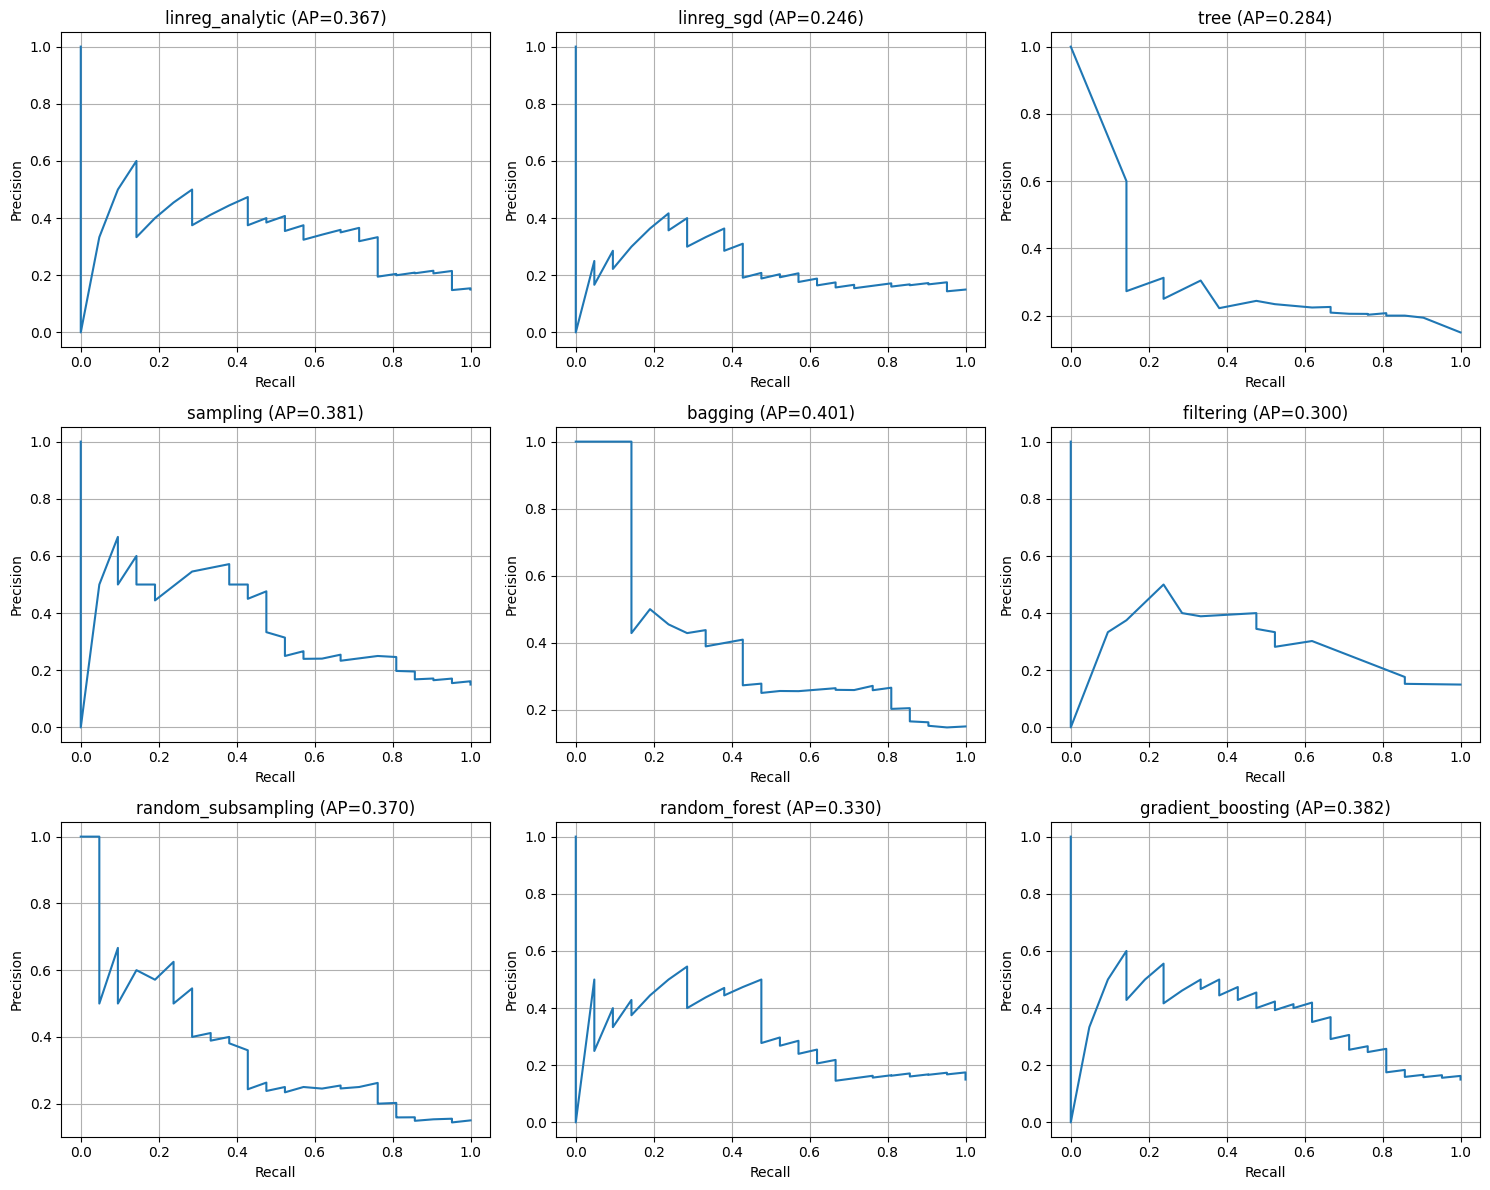

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

def get_scores(model, kind, X):
    if kind == "reg":
        return model.predict(X)
    if hasattr(model, "predict_proba"):
        return model.predict_proba(X)[:, 1]
    if hasattr(model, "decision_function"):
        s = model.decision_function(X)
        if s.ndim == 1:
            return s
        return s[:, 1]
    y = model.predict(X)
    return np.where(y == 1, 1.0, -1.0)

y_val_bin = (y_val == 1).astype(int)

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.ravel()

for i, (name, (kind, model, thr)) in enumerate(models.items()):
    scores = get_scores(model, kind, X_val)
    precision, recall, _ = precision_recall_curve(y_val_bin, scores)
    ap = average_precision_score(y_val_bin, scores)

    ax = axes[i]
    ax.plot(recall, precision)
    ax.set_title(f"{name} (AP={ap:.3f})")
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.grid(True)

for j in range(len(models), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
from sklearn.metrics import f1_score

def get_scores(model, kind, X):
    if kind == "reg":
        return model.predict(X)
    if hasattr(model, "predict_proba"):
        return model.predict_proba(X)[:, 1]
    if hasattr(model, "decision_function"):
        s = model.decision_function(X)
        if s.ndim == 1:
            return s
        return s[:, 1]
    y = model.predict(X)
    return np.where(y == 1, 1.0, -1.0)

def pred_with_threshold(model, kind, X, thr):
    s = get_scores(model, kind, X)
    return np.where(s >= thr, 1, -1)

test_f1 = {}
for name, (kind, model, thr) in models.items():
    y_pred_test = pred_with_threshold(model, kind, X_test, thr)
    test_f1[name] = f1_score(y_test, y_pred_test, pos_label=1)

print("Test F1 (single run):")
for name, f in sorted(test_f1.items(), key=lambda x: -x[1]):
    print(f"{name}: {f:.4f}")

top_k = 3
top_names = [n for n, _ in sorted(test_f1.items(), key=lambda x: -x[1])[:top_k]]
baseline = "linreg_analytic"
if baseline not in top_names and baseline in models:
    top_names.append(baseline)

print("\nWill bootstrap these models:", top_names)

preds_test = {}
for name in top_names:
    kind, model, thr = models[name]
    preds_test[name] = pred_with_threshold(model, kind, X_test, thr)

y_test_arr = np.asarray(y_test)
n = len(y_test_arr)

n_boot = 500
rng = np.random.RandomState(42)
m = len(top_names)
scores = np.zeros((n_boot, m))

for b in range(n_boot):
    idx = rng.randint(0, n, size=n)
    y_b = y_test_arr[idx]
    for j, name in enumerate(top_names):
        y_pred_b = preds_test[name][idx]
        scores[b, j] = f1_score(y_b, y_pred_b, pos_label=1)

mean_f1 = scores.mean(axis=0)
print("\nBootstrap mean F1 on test:")
for name, m_f1 in zip(top_names, mean_f1):
    print(f"{name}: {m_f1:.4f}")

best_idx = np.argmax(mean_f1)
best_name = top_names[best_idx]
print("\nReference (best by mean F1):", best_name)

print("\nPairwise differences vs best (F1_other - F1_best):")
for j, name in enumerate(top_names):
    diff = scores[:, j] - scores[:, best_idx]
    mean_diff = diff.mean()
    ci_low, ci_high = np.percentile(diff, [2.5, 97.5])
    p_better = (diff > 0).mean()
    print(
        f"{name:20s} "
        f"mean_diff={mean_diff:+.4f}, "
        f"95% CI=({ci_low:+.4f}, {ci_high:+.4f}), "
        f"P(F1_other > F1_best)={p_better:.3f}"
    )


Test F1 (single run):
linreg_analytic: 0.4211
filtering: 0.4103
random_forest: 0.3810
gradient_boosting: 0.3684
sampling: 0.3077
tree: 0.3043
bagging: 0.2703
random_subsampling: 0.2273
linreg_sgd: 0.1463

Will bootstrap these models: ['linreg_analytic', 'filtering', 'random_forest']

Bootstrap mean F1 on test:
linreg_analytic: 0.4120
filtering: 0.4056
random_forest: 0.3770

Reference (best by mean F1): linreg_analytic

Pairwise differences vs best (F1_other - F1_best):
linreg_analytic      mean_diff=+0.0000, 95% CI=(+0.0000, +0.0000), P(F1_other > F1_best)=0.000
filtering            mean_diff=-0.0064, 95% CI=(-0.2137, +0.2280), P(F1_other > F1_best)=0.456
random_forest        mean_diff=-0.0350, 95% CI=(-0.2290, +0.1642), P(F1_other > F1_best)=0.372


In [30]:
import numpy as np
import optuna

from sklearn.linear_model import LinearRegression, SGDRegressor, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

from catboost import CatBoostClassifier


def get_scores(model, kind, X):
    if kind == "reg":
        return model.predict(X)
    if hasattr(model, "predict_proba"):
        return model.predict_proba(X)[:, 1]
    if hasattr(model, "decision_function"):
        s = model.decision_function(X)
        if s.ndim == 1:
            return s
        return s[:, 1]
    y = model.predict(X)
    return np.where(y == 1, 1.0, -1.0)


def compute_threshold_for_top_frac(scores, frac):
    scores = np.asarray(scores)
    n = len(scores)
    k = max(1, int(round(frac * n)))
    sorted_scores = np.sort(scores)[::-1]
    thr = sorted_scores[k - 1]
    return thr


def pred_with_threshold(model, kind, X, thr):
    s = get_scores(model, kind, X)
    return np.where(s >= thr, 1, -1)


def tune_with_optuna(build_model, kind, X_train, y_train, X_val, y_val, n_trials, desired_pos_frac):
    best_model = None
    best_thr = None
    best_score = -np.inf

    def objective(trial):
        nonlocal best_model, best_thr, best_score
        model = build_model(trial)
        model.fit(X_train, y_train)

        s_val = get_scores(model, kind, X_val)
        thr = compute_threshold_for_top_frac(s_val, desired_pos_frac)
        y_val_pred = np.where(s_val >= thr, 1, -1)

        score = f1_score(y_val, y_val_pred, pos_label=1)

        if score > best_score:
            best_score = score
            best_model = model
            best_thr = thr

        return score

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials)
    return best_model, best_thr, study


desired_pos_frac = 0.15
n_features = X_train.shape[1]
max_k = max(1, min(50, n_features - 1))


def build_linreg_analytic(trial):
    return LinearRegression(fit_intercept=False)


def build_linreg_sgd(trial):
    alpha = trial.suggest_float("alpha", 1e-6, 1e-2, log=True)
    eta0 = trial.suggest_float("eta0", 1e-3, 1.0, log=True)
    max_iter = trial.suggest_int("max_iter", 500, 5000)
    return SGDRegressor(
        loss="squared_error",
        penalty="l2",
        alpha=alpha,
        learning_rate="constant",
        eta0=eta0,
        max_iter=max_iter,
        tol=1e-3,
        fit_intercept=False,
        random_state=42
    )


def build_logreg_l2(trial):
    C = trial.suggest_float("C", 1e-3, 1e3, log=True)
    return LogisticRegression(
        penalty="l2",
        C=C,
        solver="saga",
        fit_intercept=False,
        class_weight="balanced",
        max_iter=5000,
        random_state=42,
        n_jobs=-1
    )


def build_logreg_l1(trial):
    C = trial.suggest_float("C", 1e-3, 1e3, log=True)
    return LogisticRegression(
        penalty="l1",
        C=C,
        solver="saga",
        fit_intercept=False,
        class_weight="balanced",
        max_iter=5000,
        random_state=42,
        n_jobs=-1
    )


def build_logreg_elastic(trial):
    C = trial.suggest_float("C", 1e-3, 1e3, log=True)
    l1_ratio = trial.suggest_float("l1_ratio", 0.0, 1.0)
    return LogisticRegression(
        penalty="elasticnet",
        C=C,
        l1_ratio=l1_ratio,
        solver="saga",
        fit_intercept=False,
        class_weight="balanced",
        max_iter=5000,
        random_state=42,
        n_jobs=-1
    )


def build_tree(trial):
    max_depth = trial.suggest_int("max_depth", 1, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 50)
    return DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        class_weight="balanced",
        random_state=42
    )


def build_sampling(trial):
    n_estimators = trial.suggest_int("n_estimators", 5, 200)
    max_samples = trial.suggest_float("max_samples", 0.3, 1.0)
    base = DecisionTreeClassifier(class_weight="balanced", random_state=42)
    return BaggingClassifier(
        estimator=base,
        n_estimators=n_estimators,
        max_samples=max_samples,
        bootstrap=True,
        n_jobs=-1,
        random_state=42
    )


def build_bagging(trial):
    n_estimators = trial.suggest_int("n_estimators", 5, 200)
    max_samples = trial.suggest_float("max_samples", 0.5, 1.0)
    base = DecisionTreeClassifier(class_weight="balanced", random_state=42)
    return BaggingClassifier(
        estimator=base,
        n_estimators=n_estimators,
        max_samples=max_samples,
        bootstrap=True,
        n_jobs=-1,
        random_state=42
    )


def build_filtering(trial):
    k = trial.suggest_int("k", 1, max_k)
    max_depth = trial.suggest_int("max_depth", 1, 15)
    return make_pipeline(
        FunctionTransformer(lambda X: X[:, 1:]),
        SelectKBest(f_classif, k=k),
        DecisionTreeClassifier(
            max_depth=max_depth,
            class_weight="balanced",
            random_state=42
        )
    )


def build_random_subsampling(trial):
    n_estimators = trial.suggest_int("n_estimators", 5, 200)
    max_samples = trial.suggest_float("max_samples", 0.3, 1.0)
    base = DecisionTreeClassifier(class_weight="balanced", random_state=42)
    return BaggingClassifier(
        estimator=base,
        n_estimators=n_estimators,
        max_samples=max_samples,
        bootstrap=False,
        n_jobs=-1,
        random_state=42
    )


def build_random_forest(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 400)
    max_depth = trial.suggest_int("max_depth", 3, 20)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2"])
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 20)
    return RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        max_features=max_features,
        min_samples_leaf=min_samples_leaf,
        class_weight="balanced",
        n_jobs=-1,
        random_state=42
    )


def build_gradient_boosting(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 300)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3, log=True)
    max_depth = trial.suggest_int("max_depth", 1, 5)
    subsample = trial.suggest_float("subsample", 0.5, 1.0)
    return GradientBoostingClassifier(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        subsample=subsample,
        random_state=42
    )


def build_catboost(trial):
    depth = trial.suggest_int("depth", 3, 8)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3, log=True)
    n_estimators = trial.suggest_int("n_estimators", 50, 500)
    l2_leaf_reg = trial.suggest_float("l2_leaf_reg", 1.0, 10.0)
    bagging_temperature = trial.suggest_float("bagging_temperature", 0.0, 1.0)
    border_count = trial.suggest_int("border_count", 32, 255)
    return CatBoostClassifier(
        depth=depth,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        l2_leaf_reg=l2_leaf_reg,
        bagging_temperature=bagging_temperature,
        border_count=border_count,
        loss_function="Logloss",
        auto_class_weights="Balanced",
        random_seed=42,
        verbose=False
    )


search_space = [
    ("linreg_analytic", "reg", build_linreg_analytic, 5),
    ("linreg_sgd", "reg", build_linreg_sgd, 30),
    ("logreg_l2", "clf", build_logreg_l2, 40),
    ("logreg_l1", "clf", build_logreg_l1, 40),
    ("logreg_elastic", "clf", build_logreg_elastic, 40),
    ("tree", "clf", build_tree, 30),
    ("sampling", "clf", build_sampling, 30),
    ("bagging", "clf", build_bagging, 30),
    ("filtering", "clf", build_filtering, 30),
    ("random_subsampling", "clf", build_random_subsampling, 30),
    ("random_forest", "clf", build_random_forest, 40),
    ("gradient_boosting", "clf", build_gradient_boosting, 40),
    ("catboost", "clf", build_catboost, 50),
]

models = {}      # name -> (kind, model, thr)
studies = {}     # name -> optuna study

for name, kind, builder, n_trials in search_space:
    best_model, best_thr, study = tune_with_optuna(
        builder,
        kind,
        X_train,
        y_train,
        X_val,
        y_val,
        n_trials=n_trials,
        desired_pos_frac=desired_pos_frac
    )
    models[name] = (kind, best_model, best_thr)
    studies[name] = study
    print(f"{name}: best_val_f1={study.best_value:.4f}, best_thr={best_thr:.4f}")


print("\n=== final metrics with top-15% thresholds (picked inside Optuna) ===")
for name, (kind, model, thr) in models.items():
    y_tr = pred_with_threshold(model, kind, X_train, thr)
    y_va = pred_with_threshold(model, kind, X_val, thr)
    y_te = pred_with_threshold(model, kind, X_test, thr)

    train_acc = accuracy_score(y_train, y_tr)
    val_acc = accuracy_score(y_val, y_va)
    test_acc = accuracy_score(y_test, y_te)

    val_f1 = f1_score(y_val, y_va, pos_label=1)
    val_rec = recall_score(y_val, y_va, pos_label=1)
    val_prec = precision_score(y_val, y_va, pos_label=1)

    val_pos_frac = (y_va == 1).mean()

    print(
        f"{name}: "
        f"train_acc={train_acc:.4f}, "
        f"val_acc={val_acc:.4f}, "
        f"test_acc={test_acc:.4f}, "
        f"val_f1={val_f1:.4f}, "
        f"val_recall={val_rec:.4f}, "
        f"val_prec={val_prec:.4f}, "
        f"val_pos_frac={val_pos_frac:.3f}"
    )


[I 2025-11-26 14:31:51,613] A new study created in memory with name: no-name-c98bd9cd-b447-49ac-be88-673959cd9e4f
[I 2025-11-26 14:31:51,654] Trial 0 finished with value: 0.42857142857142855 and parameters: {}. Best is trial 0 with value: 0.42857142857142855.
[I 2025-11-26 14:31:51,693] Trial 1 finished with value: 0.42857142857142855 and parameters: {}. Best is trial 0 with value: 0.42857142857142855.
[I 2025-11-26 14:31:51,730] Trial 2 finished with value: 0.42857142857142855 and parameters: {}. Best is trial 0 with value: 0.42857142857142855.
[I 2025-11-26 14:31:51,764] Trial 3 finished with value: 0.42857142857142855 and parameters: {}. Best is trial 0 with value: 0.42857142857142855.
[I 2025-11-26 14:31:51,789] Trial 4 finished with value: 0.42857142857142855 and parameters: {}. Best is trial 0 with value: 0.42857142857142855.
[I 2025-11-26 14:31:51,795] A new study created in memory with name: no-name-167378db-2f59-4e97-b0af-a405e844bced
[I 2025-11-26 14:31:51,818] Trial 0 finish

linreg_analytic: best_val_f1=0.4286, best_thr=-0.3476


[I 2025-11-26 14:31:51,993] Trial 7 finished with value: 0.047619047619047616 and parameters: {'alpha': 0.009639532226359852, 'eta0': 0.015693589358882182, 'max_iter': 3025}. Best is trial 6 with value: 0.3333333333333333.
[I 2025-11-26 14:31:52,013] Trial 8 finished with value: 0.3333333333333333 and parameters: {'alpha': 2.1785906066405917e-05, 'eta0': 0.004113411098049544, 'max_iter': 581}. Best is trial 6 with value: 0.3333333333333333.
[I 2025-11-26 14:31:52,046] Trial 9 finished with value: 0.0 and parameters: {'alpha': 8.822824060943494e-06, 'eta0': 0.5848428402671375, 'max_iter': 3774}. Best is trial 6 with value: 0.3333333333333333.
[I 2025-11-26 14:31:52,101] Trial 10 finished with value: 0.047619047619047616 and parameters: {'alpha': 0.0004958274423016372, 'eta0': 0.0011923880767205435, 'max_iter': 1732}. Best is trial 6 with value: 0.3333333333333333.
[I 2025-11-26 14:31:52,159] Trial 11 finished with value: 0.3333333333333333 and parameters: {'alpha': 2.9982322633517188e-0

linreg_sgd: best_val_f1=0.3333, best_thr=1306866726092.7690


[I 2025-11-26 14:32:00,610] Trial 0 finished with value: 0.38095238095238093 and parameters: {'C': 0.006659270920111562}. Best is trial 0 with value: 0.38095238095238093.
[I 2025-11-26 14:32:08,901] Trial 1 finished with value: 0.38095238095238093 and parameters: {'C': 0.010143992295532882}. Best is trial 0 with value: 0.38095238095238093.
c:\Users\zaits\VScodeProjects\PythonKernel\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2025-11-26 14:32:18,742] Trial 2 finished with value: 0.38095238095238093 and parameters: {'C': 9.796757177229367}. Best is trial 0 with value: 0.38095238095238093.
c:\Users\zaits\VScodeProjects\PythonKernel\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2025-11-26 14:32:28,727] Trial 3 finished with value: 0.38095238095238093 and param

logreg_l2: best_val_f1=0.4286, best_thr=0.5118


c:\Users\zaits\VScodeProjects\PythonKernel\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2025-11-26 14:36:45,996] Trial 0 finished with value: 0.38095238095238093 and parameters: {'C': 1.106041672444461}. Best is trial 0 with value: 0.38095238095238093.
c:\Users\zaits\VScodeProjects\PythonKernel\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2025-11-26 14:36:58,676] Trial 1 finished with value: 0.38095238095238093 and parameters: {'C': 0.8033173835455855}. Best is trial 0 with value: 0.38095238095238093.
c:\Users\zaits\VScodeProjects\PythonKernel\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2025-11-26 14:37:10,290] Trial 2 finished with value: 

logreg_l1: best_val_f1=0.3810, best_thr=0.5544


[I 2025-11-26 14:42:45,109] Trial 1 finished with value: 0.33962264150943394 and parameters: {'C': 0.0039007516235511, 'l1_ratio': 0.7309362661306297}. Best is trial 0 with value: 0.33962264150943394.
[I 2025-11-26 14:42:53,916] Trial 2 finished with value: 0.19047619047619047 and parameters: {'C': 0.020849459565533753, 'l1_ratio': 0.9721068503627983}. Best is trial 0 with value: 0.33962264150943394.
c:\Users\zaits\VScodeProjects\PythonKernel\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2025-11-26 14:43:07,144] Trial 3 finished with value: 0.38095238095238093 and parameters: {'C': 5.091015566434799, 'l1_ratio': 0.8770147090172503}. Best is trial 3 with value: 0.38095238095238093.
[I 2025-11-26 14:43:08,113] Trial 4 finished with value: 0.2608695652173913 and parameters: {'C': 0.001693346835552525, 'l1_ratio': 0.7435621059554728}. Best is trial 3 with value: 0.38095238095

logreg_elastic: best_val_f1=0.3810, best_thr=0.5565


[I 2025-11-26 14:49:31,763] Trial 5 finished with value: 0.22727272727272727 and parameters: {'max_depth': 11, 'min_samples_leaf': 46}. Best is trial 3 with value: 0.3181818181818182.
[I 2025-11-26 14:49:31,819] Trial 6 finished with value: 0.14285714285714285 and parameters: {'max_depth': 10, 'min_samples_leaf': 13}. Best is trial 3 with value: 0.3181818181818182.
[I 2025-11-26 14:49:31,864] Trial 7 finished with value: 0.23809523809523808 and parameters: {'max_depth': 20, 'min_samples_leaf': 36}. Best is trial 3 with value: 0.3181818181818182.
[I 2025-11-26 14:49:31,921] Trial 8 finished with value: 0.2222222222222222 and parameters: {'max_depth': 15, 'min_samples_leaf': 16}. Best is trial 3 with value: 0.3181818181818182.
[I 2025-11-26 14:49:31,956] Trial 9 finished with value: 0.22727272727272727 and parameters: {'max_depth': 9, 'min_samples_leaf': 47}. Best is trial 3 with value: 0.3181818181818182.
[I 2025-11-26 14:49:32,012] Trial 10 finished with value: 0.2828282828282828 and p

tree: best_val_f1=0.3182, best_thr=0.7395


[I 2025-11-26 14:49:45,741] Trial 0 finished with value: 0.36363636363636365 and parameters: {'n_estimators': 90, 'max_samples': 0.5745787185050588}. Best is trial 0 with value: 0.36363636363636365.
[I 2025-11-26 14:49:46,099] Trial 1 finished with value: 0.35555555555555557 and parameters: {'n_estimators': 37, 'max_samples': 0.9478919800648595}. Best is trial 0 with value: 0.36363636363636365.
[I 2025-11-26 14:49:47,139] Trial 2 finished with value: 0.3181818181818182 and parameters: {'n_estimators': 150, 'max_samples': 0.8998664486109293}. Best is trial 0 with value: 0.36363636363636365.
[I 2025-11-26 14:49:47,968] Trial 3 finished with value: 0.37209302325581395 and parameters: {'n_estimators': 127, 'max_samples': 0.41521361256676426}. Best is trial 3 with value: 0.37209302325581395.
[I 2025-11-26 14:49:48,414] Trial 4 finished with value: 0.37209302325581395 and parameters: {'n_estimators': 55, 'max_samples': 0.9359610161972212}. Best is trial 3 with value: 0.37209302325581395.
[I 

sampling: best_val_f1=0.3810, best_thr=0.3370


[I 2025-11-26 14:50:04,301] Trial 0 finished with value: 0.38095238095238093 and parameters: {'n_estimators': 78, 'max_samples': 0.6099493116629313}. Best is trial 0 with value: 0.38095238095238093.
[I 2025-11-26 14:50:04,955] Trial 1 finished with value: 0.36363636363636365 and parameters: {'n_estimators': 66, 'max_samples': 0.904079614423686}. Best is trial 0 with value: 0.38095238095238093.
[I 2025-11-26 14:50:06,762] Trial 2 finished with value: 0.273972602739726 and parameters: {'n_estimators': 5, 'max_samples': 0.8181461761121536}. Best is trial 0 with value: 0.38095238095238093.
[I 2025-11-26 14:50:08,101] Trial 3 finished with value: 0.32558139534883723 and parameters: {'n_estimators': 154, 'max_samples': 0.7407827822119532}. Best is trial 0 with value: 0.38095238095238093.
[I 2025-11-26 14:50:21,628] Trial 4 finished with value: 0.391304347826087 and parameters: {'n_estimators': 28, 'max_samples': 0.8185645967931393}. Best is trial 4 with value: 0.391304347826087.
[I 2025-11-2

bagging: best_val_f1=0.4286, best_thr=0.3378


[I 2025-11-26 14:50:41,886] Trial 6 finished with value: 0.2828282828282828 and parameters: {'k': 41, 'max_depth': 2}. Best is trial 6 with value: 0.2828282828282828.
[I 2025-11-26 14:50:41,921] Trial 7 finished with value: 0.3333333333333333 and parameters: {'k': 7, 'max_depth': 10}. Best is trial 7 with value: 0.3333333333333333.
[I 2025-11-26 14:50:41,969] Trial 8 finished with value: 0.23809523809523808 and parameters: {'k': 26, 'max_depth': 13}. Best is trial 7 with value: 0.3333333333333333.
[I 2025-11-26 14:50:42,017] Trial 9 finished with value: 0.3111111111111111 and parameters: {'k': 41, 'max_depth': 10}. Best is trial 7 with value: 0.3333333333333333.
[I 2025-11-26 14:50:42,074] Trial 10 finished with value: 0.19047619047619047 and parameters: {'k': 20, 'max_depth': 15}. Best is trial 7 with value: 0.3333333333333333.
[I 2025-11-26 14:50:42,131] Trial 11 finished with value: 0.2191780821917808 and parameters: {'k': 32, 'max_depth': 9}. Best is trial 7 with value: 0.333333333

filtering: best_val_f1=0.4400, best_thr=0.6485


[I 2025-11-26 14:50:43,843] Trial 0 finished with value: 0.27906976744186046 and parameters: {'n_estimators': 121, 'max_samples': 0.5251485727949459}. Best is trial 0 with value: 0.27906976744186046.
[I 2025-11-26 14:50:44,090] Trial 1 finished with value: 0.3181818181818182 and parameters: {'n_estimators': 18, 'max_samples': 0.5290505241715213}. Best is trial 1 with value: 0.3181818181818182.
[I 2025-11-26 14:50:44,572] Trial 2 finished with value: 0.3181818181818182 and parameters: {'n_estimators': 61, 'max_samples': 0.6276942014588114}. Best is trial 1 with value: 0.3181818181818182.
[I 2025-11-26 14:50:45,140] Trial 3 finished with value: 0.27906976744186046 and parameters: {'n_estimators': 79, 'max_samples': 0.7752671205895585}. Best is trial 1 with value: 0.3181818181818182.
[I 2025-11-26 14:50:45,428] Trial 4 finished with value: 0.27906976744186046 and parameters: {'n_estimators': 36, 'max_samples': 0.6146462650931696}. Best is trial 1 with value: 0.3181818181818182.
[I 2025-11

random_subsampling: best_val_f1=0.3810, best_thr=0.3200


[I 2025-11-26 14:50:58,252] Trial 0 finished with value: 0.3333333333333333 and parameters: {'n_estimators': 180, 'max_depth': 7, 'max_features': 'log2', 'min_samples_leaf': 16}. Best is trial 0 with value: 0.3333333333333333.
[I 2025-11-26 14:50:58,454] Trial 1 finished with value: 0.3333333333333333 and parameters: {'n_estimators': 57, 'max_depth': 13, 'max_features': 'log2', 'min_samples_leaf': 16}. Best is trial 0 with value: 0.3333333333333333.
[I 2025-11-26 14:50:59,323] Trial 2 finished with value: 0.38095238095238093 and parameters: {'n_estimators': 240, 'max_depth': 18, 'max_features': 'sqrt', 'min_samples_leaf': 4}. Best is trial 2 with value: 0.38095238095238093.
[I 2025-11-26 14:50:59,865] Trial 3 finished with value: 0.38095238095238093 and parameters: {'n_estimators': 193, 'max_depth': 19, 'max_features': 'log2', 'min_samples_leaf': 7}. Best is trial 2 with value: 0.38095238095238093.
[I 2025-11-26 14:51:00,083] Trial 4 finished with value: 0.2857142857142857 and paramete

random_forest: best_val_f1=0.4286, best_thr=0.5029


[I 2025-11-26 14:51:12,351] Trial 1 finished with value: 0.42857142857142855 and parameters: {'n_estimators': 114, 'learning_rate': 0.08873907172604854, 'max_depth': 2, 'subsample': 0.8308875090691443}. Best is trial 1 with value: 0.42857142857142855.
[I 2025-11-26 14:51:12,493] Trial 2 finished with value: 0.3333333333333333 and parameters: {'n_estimators': 50, 'learning_rate': 0.017899259071083008, 'max_depth': 2, 'subsample': 0.8496047410930077}. Best is trial 1 with value: 0.42857142857142855.
[I 2025-11-26 14:51:12,903] Trial 3 finished with value: 0.23809523809523808 and parameters: {'n_estimators': 127, 'learning_rate': 0.01621354729548572, 'max_depth': 5, 'subsample': 0.8888780346290777}. Best is trial 1 with value: 0.42857142857142855.
[I 2025-11-26 14:51:13,292] Trial 4 finished with value: 0.38095238095238093 and parameters: {'n_estimators': 166, 'learning_rate': 0.04783183727395353, 'max_depth': 4, 'subsample': 0.8561330077928944}. Best is trial 1 with value: 0.428571428571

gradient_boosting: best_val_f1=0.4762, best_thr=0.1903


[I 2025-11-26 14:51:35,202] Trial 0 finished with value: 0.38095238095238093 and parameters: {'depth': 8, 'learning_rate': 0.1951356698581917, 'n_estimators': 429, 'l2_leaf_reg': 4.537900984215433, 'bagging_temperature': 0.6953639939310745, 'border_count': 85}. Best is trial 0 with value: 0.38095238095238093.
[I 2025-11-26 14:51:35,577] Trial 1 finished with value: 0.47619047619047616 and parameters: {'depth': 7, 'learning_rate': 0.022462346937732188, 'n_estimators': 95, 'l2_leaf_reg': 7.811051449240187, 'bagging_temperature': 0.18624882629668493, 'border_count': 192}. Best is trial 1 with value: 0.47619047619047616.
[I 2025-11-26 14:51:36,367] Trial 2 finished with value: 0.38095238095238093 and parameters: {'depth': 3, 'learning_rate': 0.18454914444105525, 'n_estimators': 465, 'l2_leaf_reg': 3.0656260207775556, 'bagging_temperature': 0.5113030674266233, 'border_count': 255}. Best is trial 1 with value: 0.47619047619047616.
[I 2025-11-26 14:51:36,649] Trial 3 finished with value: 0.42

catboost: best_val_f1=0.4762, best_thr=0.5750

=== final metrics with top-15% thresholds (picked inside Optuna) ===
linreg_analytic: train_acc=0.8517, val_acc=0.8286, test_acc=0.8483, val_f1=0.4286, val_recall=0.4286, val_prec=0.4286, val_pos_frac=0.150
linreg_sgd: train_acc=0.7548, val_acc=0.8000, test_acc=0.7241, val_f1=0.3333, val_recall=0.3333, val_prec=0.3333, val_pos_frac=0.150
logreg_l2: train_acc=0.8150, val_acc=0.8286, test_acc=0.8345, val_f1=0.4286, val_recall=0.4286, val_prec=0.4286, val_pos_frac=0.150
logreg_l1: train_acc=0.8194, val_acc=0.8143, test_acc=0.8483, val_f1=0.3810, val_recall=0.3810, val_prec=0.3810, val_pos_frac=0.150
logreg_elastic: train_acc=0.8150, val_acc=0.8143, test_acc=0.8483, val_f1=0.3810, val_recall=0.3810, val_prec=0.3810, val_pos_frac=0.150
tree: train_acc=0.8209, val_acc=0.7857, test_acc=0.7793, val_f1=0.3182, val_recall=0.3333, val_prec=0.3043, val_pos_frac=0.164
sampling: train_acc=0.9897, val_acc=0.8143, test_acc=0.7931, val_f1=0.3810, val_recal

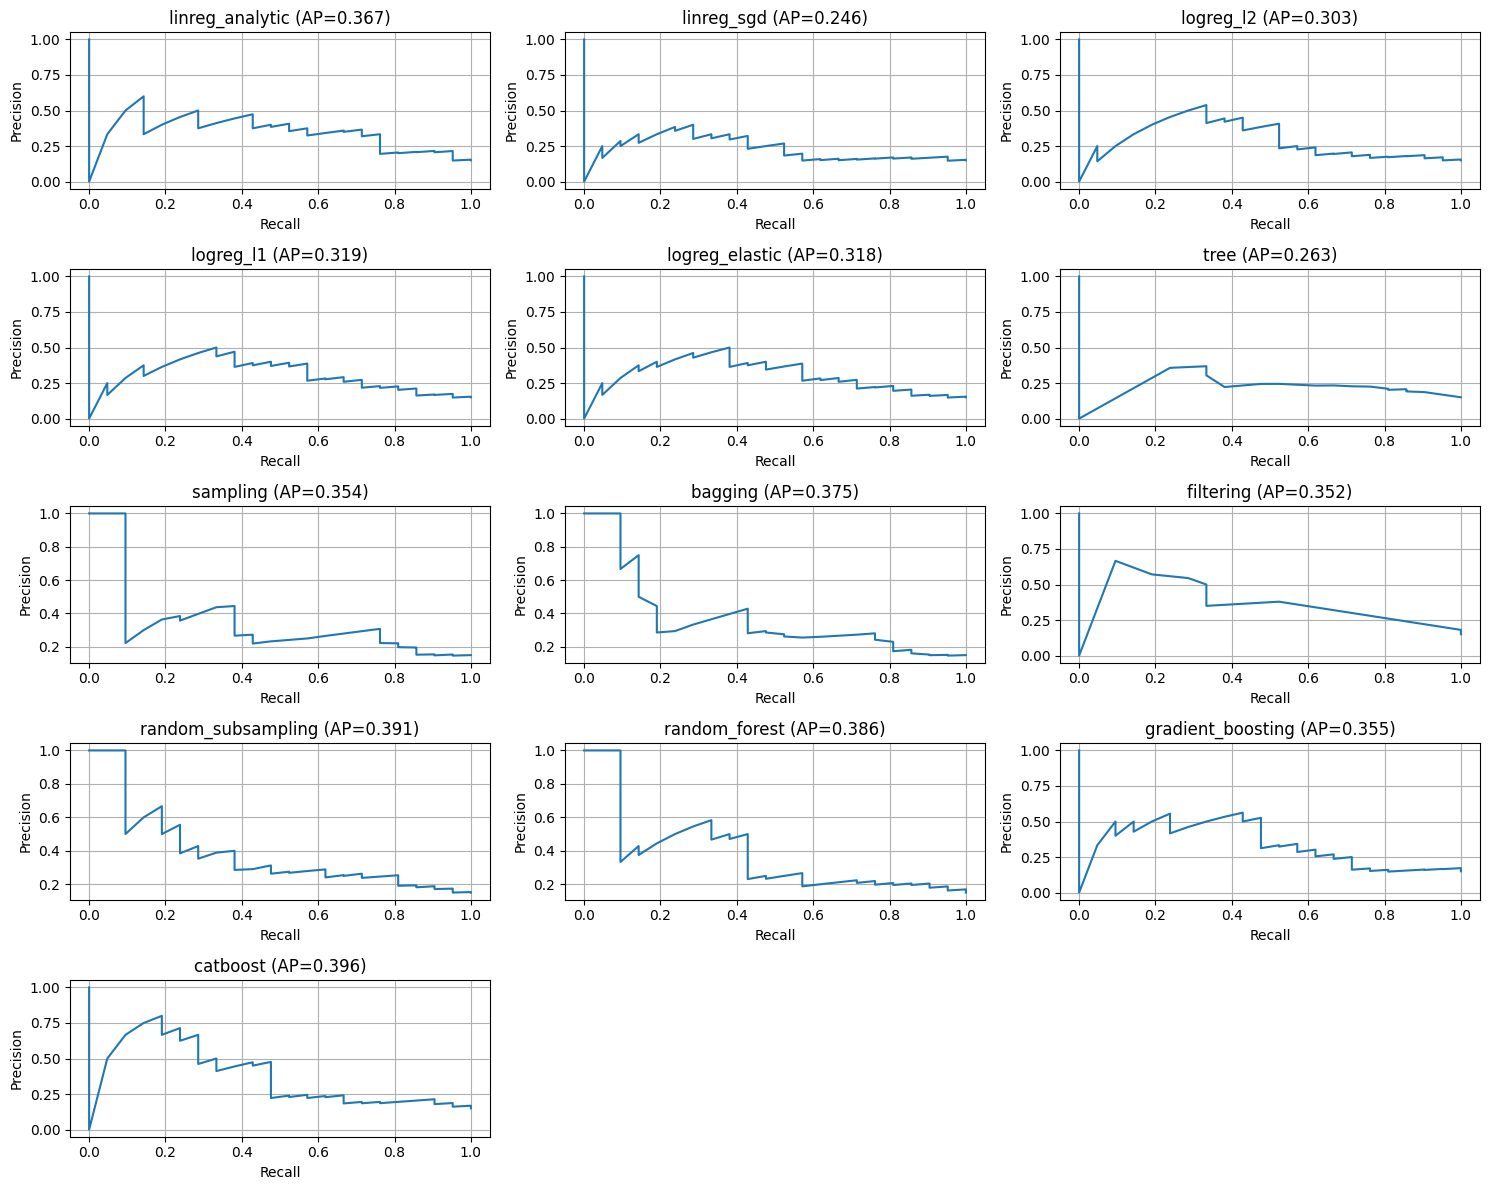

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

def get_scores(model, kind, X):
    if kind == "reg":
        return model.predict(X)
    if hasattr(model, "predict_proba"):
        return model.predict_proba(X)[:, 1]
    if hasattr(model, "decision_function"):
        s = model.decision_function(X)
        if s.ndim == 1:
            return s
        return s[:, 1]
    y = model.predict(X)
    return np.where(y == 1, 1.0, -1.0)

y_val_bin = (y_val == 1).astype(int)

fig, axes = plt.subplots(5, 3, figsize=(15, 12))
axes = axes.ravel()

for i, (name, (kind, model, thr)) in enumerate(models.items()):
    scores = get_scores(model, kind, X_val)
    precision, recall, _ = precision_recall_curve(y_val_bin, scores)
    ap = average_precision_score(y_val_bin, scores)

    ax = axes[i]
    ax.plot(recall, precision)
    ax.set_title(f"{name} (AP={ap:.3f})")
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.grid(True)

for j in range(len(models), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
from sklearn.metrics import f1_score


candidates = ["linreg_analytic", "random_forest", "catboost"]
names = [n for n in candidates if n in models]

print("Models to compare:", names)

y_test_arr = np.asarray(y_test)
n = len(y_test_arr)

preds_test = {}
for name in names:
    kind, model, thr = models[name]
    preds_test[name] = pred_with_threshold(model, kind, X_test, thr)

n_boot = 1000
rng = np.random.RandomState(42)
m = len(names)
scores = np.zeros((n_boot, m))

for b in range(n_boot):
    idx = rng.randint(0, n, size=n)
    y_b = y_test_arr[idx]
    for j, name in enumerate(names):
        y_pred_b = preds_test[name][idx]
        scores[b, j] = f1_score(y_b, y_pred_b, pos_label=1)

mean_f1 = scores.mean(axis=0)
print("\nBootstrap mean F1 on test:")
for name, m_f1 in zip(names, mean_f1):
    print(f"{name}: {m_f1:.4f}")

if "catboost" in names:
    ref_name = "catboost"
    ref_idx = names.index(ref_name)
else:
    ref_idx = int(np.argmax(mean_f1))
    ref_name = names[ref_idx]

print(f"\nReference (best or CatBoost): {ref_name}")

print("\nPairwise differences vs reference (F1_other - F1_ref):")
for j, name in enumerate(names):
    diff = scores[:, j] - scores[:, ref_idx]
    mean_diff = diff.mean()
    ci_low, ci_high = np.percentile(diff, [2.5, 97.5])
    p_better = (diff > 0).mean()
    print(
        f"{name:15s} "
        f"mean_diff={mean_diff:+.4f}, "
        f"95% CI=({ci_low:+.4f}, {ci_high:+.4f}), "
        f"P(F1_other > F1_ref)={p_better:.3f}"
    )


Models to compare: ['linreg_analytic', 'random_forest', 'catboost']

Bootstrap mean F1 on test:
linreg_analytic: 0.4111
random_forest: 0.4450
catboost: 0.5089

Reference (best or CatBoost): catboost

Pairwise differences vs reference (F1_other - F1_ref):
linreg_analytic mean_diff=-0.0978, 95% CI=(-0.3490, +0.1467), P(F1_other > F1_ref)=0.195
random_forest   mean_diff=-0.0639, 95% CI=(-0.1616, +0.0097), P(F1_other > F1_ref)=0.031
catboost        mean_diff=+0.0000, 95% CI=(+0.0000, +0.0000), P(F1_other > F1_ref)=0.000


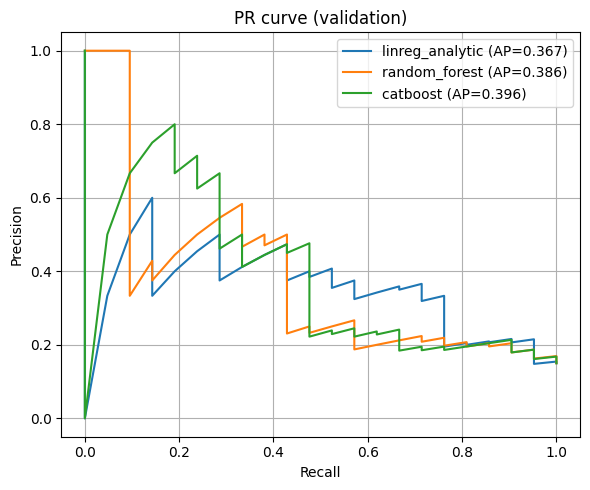

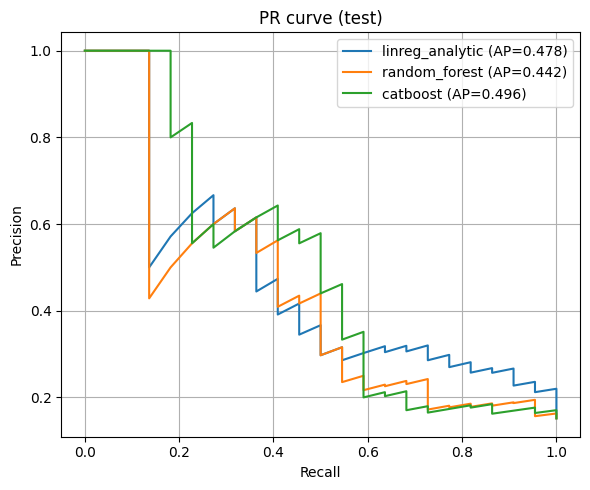

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

names = ["linreg_analytic", "random_forest", "catboost"]
names = [n for n in names if n in models]

def plot_pr_for_split(X, y, split_name):
    y_bin = (y == 1).astype(int)

    plt.figure(figsize=(6, 5))

    for name in names:
        kind, model, thr = models[name]
        scores = get_scores(model, kind, X)
        precision, recall, _ = precision_recall_curve(y_bin, scores)
        ap = average_precision_score(y_bin, scores)
        plt.plot(recall, precision, label=f"{name} (AP={ap:.3f})")

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"PR curve ({split_name})")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


plot_pr_for_split(X_val, y_val, "validation")
plot_pr_for_split(X_test, y_test, "test")


In [36]:
from sklearn.linear_model import LogisticRegression

base_meta_names = [
    "linreg_analytic",
    "logreg_l2",
    "random_forest",
    "gradient_boosting",
    "catboost",
]
base_meta_names = [n for n in base_meta_names if n in models]

print("Base models for meta:", base_meta_names)

def make_meta_features(X, base_names):
    feats = []
    for name in base_names:
        kind, model, thr = models[name]
        feats.append(get_scores(model, kind, X))
    return np.column_stack(feats)

X_train_meta = make_meta_features(X_train, base_meta_names)
X_val_meta = make_meta_features(X_val, base_meta_names)
X_test_meta = make_meta_features(X_test, base_meta_names)


def tune_meta_logreg(X_tr_meta, y_tr, X_va_meta, y_va, n_trials=40, desired_pos_frac=0.15):
    best_model = None
    best_thr = None
    best_score = -np.inf

    def objective(trial):
        nonlocal best_model, best_thr, best_score

        C = trial.suggest_float("C", 1e-3, 1e3, log=True)
        model = LogisticRegression(
            penalty="l2",
            C=C,
            solver="lbfgs",
            class_weight="balanced",
            max_iter=5000,
            random_state=42
        )
        model.fit(X_tr_meta, y_tr)

        scores_val = model.predict_proba(X_va_meta)[:, 1]
        thr = compute_threshold_for_top_frac(scores_val, desired_pos_frac)
        y_val_pred = np.where(scores_val >= thr, 1, -1)

        score = f1_score(y_va, y_val_pred, pos_label=1)

        if score > best_score:
            best_score = score
            best_model = model
            best_thr = thr

        return score

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials)

    return best_model, best_thr, study


meta_model, meta_thr, meta_study = tune_meta_logreg(
    X_train_meta,
    y_train,
    X_val_meta,
    y_val,
    n_trials=50,
    desired_pos_frac=desired_pos_frac
)

models["meta_logreg"] = ("clf", meta_model, meta_thr)
studies["meta_logreg"] = meta_study

print(f"\nmeta_logreg: best_val_f1={meta_study.best_value:.4f}, best_thr={meta_thr:.4f}")


def eval_meta_split(X_meta, y, model, thr):
    scores = model.predict_proba(X_meta)[:, 1]
    y_pred = np.where(scores >= thr, 1, -1)
    acc = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, pos_label=1)
    rec = recall_score(y, y_pred, pos_label=1)
    prec = precision_score(y, y_pred, pos_label=1)
    pos_frac = (y_pred == 1).mean()
    return acc, f1, rec, prec, pos_frac


train_acc, train_f1, train_rec, train_prec, train_pos_frac = eval_meta_split(
    X_train_meta, y_train, meta_model, meta_thr
)
val_acc, val_f1, val_rec, val_prec, val_pos_frac = eval_meta_split(
    X_val_meta, y_val, meta_model, meta_thr
)
test_acc, test_f1, test_rec, test_prec, test_pos_frac = eval_meta_split(
    X_test_meta, y_test, meta_model, meta_thr
)

print("\n=== meta_logreg metrics (top-15% threshold on val) ===")
print(
    f"train_acc={train_acc:.4f}, "
    f"val_acc={val_acc:.4f}, "
    f"test_acc={test_acc:.4f}, "
    f"val_f1={val_f1:.4f}, "
    f"val_recall={val_rec:.4f}, "
    f"val_prec={val_prec:.4f}, "
    f"val_pos_frac={val_pos_frac:.3f}"
)
print(
    f"test_f1={test_f1:.4f}, "
    f"test_recall={test_rec:.4f}, "
    f"test_prec={test_prec:.4f}, "
    f"test_pos_frac={test_pos_frac:.3f}"
)


Base models for meta: ['linreg_analytic', 'logreg_l2', 'random_forest', 'gradient_boosting', 'catboost']


[I 2025-11-26 15:14:10,778] A new study created in memory with name: no-name-39237e19-e7c2-4d72-8e15-0cd9a8e282a6
[I 2025-11-26 15:14:10,795] Trial 0 finished with value: 0.47619047619047616 and parameters: {'C': 343.2038512006783}. Best is trial 0 with value: 0.47619047619047616.
[I 2025-11-26 15:14:10,803] Trial 1 finished with value: 0.47619047619047616 and parameters: {'C': 0.014491778917135111}. Best is trial 0 with value: 0.47619047619047616.
[I 2025-11-26 15:14:10,815] Trial 2 finished with value: 0.47619047619047616 and parameters: {'C': 5.932202541707112}. Best is trial 0 with value: 0.47619047619047616.
[I 2025-11-26 15:14:10,827] Trial 3 finished with value: 0.47619047619047616 and parameters: {'C': 941.5576376617665}. Best is trial 0 with value: 0.47619047619047616.
[I 2025-11-26 15:14:10,837] Trial 4 finished with value: 0.47619047619047616 and parameters: {'C': 1.3517847264586416}. Best is trial 0 with value: 0.47619047619047616.
[I 2025-11-26 15:14:10,850] Trial 5 finish


meta_logreg: best_val_f1=0.4762, best_thr=0.0180

=== meta_logreg metrics (top-15% threshold on val) ===
train_acc=0.9971, val_acc=0.8429, test_acc=0.8069, val_f1=0.4762, val_recall=0.4762, val_prec=0.4762, val_pos_frac=0.150
test_f1=0.3636, test_recall=0.3636, test_prec=0.3636, test_pos_frac=0.152


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

class XGBBinaryWrapper(XGBClassifier):
    def fit(self, X, y, **kwargs):
        y_enc = (np.asarray(y) == 1).astype(int)
        return super().fit(X, y_enc, **kwargs)

def build_gb_sklearn(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 300)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3, log=True)
    max_depth = trial.suggest_int("max_depth", 1, 5)
    subsample = trial.suggest_float("subsample", 0.5, 1.0)
    return GradientBoostingClassifier(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        subsample=subsample,
        random_state=42
    )

def build_xgboost(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 400)
    max_depth = trial.suggest_int("max_depth", 2, 8)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3, log=True)
    subsample = trial.suggest_float("subsample", 0.5, 1.0)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.5, 1.0)
    reg_lambda = trial.suggest_float("reg_lambda", 1e-3, 10.0, log=True)
    return XGBBinaryWrapper(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        reg_lambda=reg_lambda,
        objective="binary:logistic",
        eval_metric="logloss",
        n_jobs=-1,
        tree_method="hist",
        random_state=42,
        use_label_encoder=False
    )

def build_lightgbm(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 400)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3, log=True)
    num_leaves = trial.suggest_int("num_leaves", 16, 64)
    max_depth = trial.suggest_int("max_depth", 3, 10)
    subsample = trial.suggest_float("subsample", 0.5, 1.0)       
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.5, 1.0)
    reg_lambda = trial.suggest_float("reg_lambda", 0.0, 10.0)
    min_child_samples = trial.suggest_int("min_child_samples", 5, 50)
    return LGBMClassifier(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        num_leaves=num_leaves,
        max_depth=max_depth,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        reg_lambda=reg_lambda,
        min_child_samples=min_child_samples,
        class_weight="balanced",
        objective="binary",
        n_jobs=-1,
        random_state=42
    )

def build_catboost_boost(trial):
    depth = trial.suggest_int("depth", 3, 8)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3, log=True)
    n_estimators = trial.suggest_int("n_estimators", 50, 500)
    l2_leaf_reg = trial.suggest_float("l2_leaf_reg", 1.0, 10.0)
    bagging_temperature = trial.suggest_float("bagging_temperature", 0.0, 1.0)
    border_count = trial.suggest_int("border_count", 32, 255)
    return CatBoostClassifier(
        depth=depth,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        l2_leaf_reg=l2_leaf_reg,
        bagging_temperature=bagging_temperature,
        border_count=border_count,
        loss_function="Logloss",
        auto_class_weights="Balanced",
        random_seed=42,
        verbose=False
    )

boost_search_space = [
    ("gb_sklearn", "clf", build_gb_sklearn, 40),
    ("xgboost", "clf", build_xgboost, 60),
    ("lightgbm", "clf", build_lightgbm, 60),
    ("catboost_lib", "clf", build_catboost_boost, 60),
]

boost_models = {}
boost_studies = {}

for name, kind, builder, n_trials in boost_search_space:
    best_model, best_thr, study = tune_with_optuna(
        builder,
        kind,
        X_train,
        y_train,
        X_val,
        y_val,
        n_trials=n_trials,
        desired_pos_frac=desired_pos_frac
    )
    boost_models[name] = (kind, best_model, best_thr)
    boost_studies[name] = study
    models[name] = (kind, best_model, best_thr)
    studies[name] = study

    print(f"{name}: best_val_f1={study.best_value:.4f}, best_thr={best_thr:.4f}")

print("\n=== BOOST METRICS (top-15% thresholds, picked inside Optuna) ===")
for name, (kind, model, thr) in boost_models.items():
    y_tr = pred_with_threshold(model, kind, X_train, thr)
    y_va = pred_with_threshold(model, kind, X_val, thr)
    y_te = pred_with_threshold(model, kind, X_test, thr)

    train_acc = accuracy_score(y_train, y_tr)
    val_acc = accuracy_score(y_val, y_va)
    test_acc = accuracy_score(y_test, y_te)

    val_f1 = f1_score(y_val, y_va, pos_label=1)
    val_rec = recall_score(y_val, y_va, pos_label=1)
    val_prec = precision_score(y_val, y_va, pos_label=1)
    val_pos_frac = (y_va == 1).mean()

    print(
        f"{name}: "
        f"train_acc={train_acc:.4f}, "
        f"val_acc={val_acc:.4f}, "
        f"test_acc={test_acc:.4f}, "
        f"val_f1={val_f1:.4f}, "
        f"val_recall={val_rec:.4f}, "
        f"val_prec={val_prec:.4f}, "
        f"val_pos_frac={val_pos_frac:.3f}"
    )


[I 2025-11-26 15:33:02,560] A new study created in memory with name: no-name-e8451ea8-bd28-4313-a23a-b5fbab789d39
[I 2025-11-26 15:33:03,401] Trial 0 finished with value: 0.3333333333333333 and parameters: {'n_estimators': 208, 'learning_rate': 0.020406237315063826, 'max_depth': 3, 'subsample': 0.8270812711294117}. Best is trial 0 with value: 0.3333333333333333.
[I 2025-11-26 15:33:04,427] Trial 1 finished with value: 0.38095238095238093 and parameters: {'n_estimators': 263, 'learning_rate': 0.01025790600745954, 'max_depth': 4, 'subsample': 0.6843506438144968}. Best is trial 1 with value: 0.38095238095238093.
[I 2025-11-26 15:33:04,917] Trial 2 finished with value: 0.3333333333333333 and parameters: {'n_estimators': 205, 'learning_rate': 0.016898955290705175, 'max_depth': 1, 'subsample': 0.8961049113250914}. Best is trial 1 with value: 0.38095238095238093.
[I 2025-11-26 15:33:05,679] Trial 3 finished with value: 0.38095238095238093 and parameters: {'n_estimators': 241, 'learning_rate':

gb_sklearn: best_val_f1=0.5238, best_thr=0.2719


[I 2025-11-26 15:34:03,158] Trial 0 finished with value: 0.3333333333333333 and parameters: {'n_estimators': 331, 'max_depth': 4, 'learning_rate': 0.12500352527426126, 'subsample': 0.7705541198875634, 'colsample_bytree': 0.842214986350583, 'reg_lambda': 6.590093414152179}. Best is trial 0 with value: 0.3333333333333333.
c:\Users\zaits\VScodeProjects\PythonKernel\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [15:34:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[I 2025-11-26 15:34:04,451] Trial 1 finished with value: 0.3333333333333333 and parameters: {'n_estimators': 135, 'max_depth': 8, 'learning_rate': 0.0773353501838414, 'subsample': 0.6912996781427014, 'colsample_bytree': 0.8610131029831978, 'reg_lambda': 0.08072546092298066}. Best is trial 0 with value: 0.3333333333333333.
c:\Users\zaits\VScodeProjects\PythonKernel\.venv\Lib\site-packages\xgboos

xgboost: best_val_f1=0.4286, best_thr=0.3026
[LightGBM] [Info] Number of positive: 102, number of negative: 579
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,002169 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 996
[LightGBM] [Info] Number of data points in the train set: 681, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0,500000 -> initscore=0,000000
[LightGBM] [Info] Start training from score 0,000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

c:\Users\zaits\VScodeProjects\PythonKernel\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-11-26 15:34:43,057] Trial 0 finished with value: 0.3333333333333333 and parameters: {'n_estimators': 153, 'learning_rate': 0.0370751439296595, 'num_leaves': 50, 'max_depth': 8, 'subsample': 0.5566926395621727, 'colsample_bytree': 0.6730550790710101, 'reg_lambda': 6.785544926362129, 'min_child_samples': 20}. Best is trial 0 with value: 0.3333333333333333.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 102, number of negative: 579
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0,003220 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1012
[LightGBM] [Info] Number of data points in the train set: 681, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0,500000 -> initscore=0,000000
[LightGBM] [Info] Start training from score 0,000000


c:\Users\zaits\VScodeProjects\PythonKernel\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-11-26 15:34:45,815] Trial 1 finished with value: 0.2857142857142857 and parameters: {'n_estimators': 211, 'learning_rate': 0.08323744041358516, 'num_leaves': 20, 'max_depth': 10, 'subsample': 0.7735837225835029, 'colsample_bytree': 0.9426288869865491, 'reg_lambda': 5.577294943299301, 'min_child_samples': 14}. Best is trial 0 with value: 0.3333333333333333.


[LightGBM] [Info] Number of positive: 102, number of negative: 579
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0,002623 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 998
[LightGBM] [Info] Number of data points in the train set: 681, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0,500000 -> initscore=0,000000
[LightGBM] [Info] Start training from score 0,000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

c:\Users\zaits\VScodeProjects\PythonKernel\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-11-26 15:34:46,968] Trial 2 finished with value: 0.2857142857142857 and parameters: {'n_estimators': 224, 'learning_rate': 0.04145389991889851, 'num_leaves': 20, 'max_depth': 4, 'subsample': 0.8361961395767649, 'colsample_bytree': 0.8307528907889232, 'reg_lambda': 4.534031466226484, 'min_child_samples': 18}. Best is trial 0 with value: 0.3333333333333333.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\zaits\VScodeProjects\PythonKernel\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-11-26 15:34:48,581] Trial 3 finished with value: 0.2857142857142857 and parameters: {'n_estimators': 282, 'learning_rate': 0.27609167213579994, 'num_leaves': 22, 'max_depth': 5, 'subsample': 0.9295308373681486, 'colsample_bytree': 0.9540514376095725, 'reg_lambda': 9.242043792188046, 'min_child_samples': 20}. Best is trial 0 with value: 0.3333333333333333.


[LightGBM] [Info] Number of positive: 102, number of negative: 579
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0,003467 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 996
[LightGBM] [Info] Number of data points in the train set: 681, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0,500000 -> initscore=0,000000
[LightGBM] [Info] Start training from score 0,000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

c:\Users\zaits\VScodeProjects\PythonKernel\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-11-26 15:34:49,809] Trial 4 finished with value: 0.3333333333333333 and parameters: {'n_estimators': 388, 'learning_rate': 0.07567955901166692, 'num_leaves': 60, 'max_depth': 3, 'subsample': 0.9882252880939577, 'colsample_bytree': 0.695088379747806, 'reg_lambda': 3.911925782473925, 'min_child_samples': 22}. Best is trial 0 with value: 0.3333333333333333.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\zaits\VScodeProjects\PythonKernel\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-11-26 15:34:50,858] Trial 5 finished with value: 0.3333333333333333 and parameters: {'n_estimators': 166, 'learning_rate': 0.020878709707832375, 'num_leaves': 34, 'max_depth': 10, 'subsample': 0.8072514837784617, 'colsample_bytree': 0.5804789653550155, 'reg_lambda': 7.763397500811897, 'min_child_samples': 42}. Best is trial 0 with value: 0.3333333333333333.


[LightGBM] [Info] Number of positive: 102, number of negative: 579
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0,002215 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 990
[LightGBM] [Info] Number of data points in the train set: 681, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0,500000 -> initscore=0,000000
[LightGBM] [Info] Start training from score 0,000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

c:\Users\zaits\VScodeProjects\PythonKernel\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-11-26 15:34:51,793] Trial 6 finished with value: 0.2857142857142857 and parameters: {'n_estimators': 90, 'learning_rate': 0.025516330474022342, 'num_leaves': 34, 'max_depth': 8, 'subsample': 0.6380680777288102, 'colsample_bytree': 0.7293967234410662, 'reg_lambda': 9.123227043196014, 'min_child_samples': 27}. Best is trial 0 with value: 0.3333333333333333.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 102, number of negative: 579
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0,002391 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 994
[LightGBM] [Info] Number of data points in the train set: 681, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0,500000 -> initscore=0,000000
[LightGBM] [Info] Start training from score 0,000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

c:\Users\zaits\VScodeProjects\PythonKernel\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-11-26 15:34:52,489] Trial 7 finished with value: 0.2857142857142857 and parameters: {'n_estimators': 212, 'learning_rate': 0.2948238329433178, 'num_leaves': 27, 'max_depth': 3, 'subsample': 0.8149635585165071, 'colsample_bytree': 0.794157670425053, 'reg_lambda': 4.299663494964094, 'min_child_samples': 24}. Best is trial 0 with value: 0.3333333333333333.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\zaits\VScodeProjects\PythonKernel\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-11-26 15:34:53,477] Trial 8 finished with value: 0.3333333333333333 and parameters: {'n_estimators': 264, 'learning_rate': 0.2148063553142299, 'num_leaves': 39, 'max_depth': 3, 'subsample': 0.6000376406715245, 'colsample_bytree': 0.5440607055079777, 'reg_lambda': 9.937123297797601, 'min_child_samples': 18}. Best is trial 0 with value: 0.3333333333333333.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 102, number of negative: 579
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0,001064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 972
[LightGBM] [Info] Number of data points in the train set: 681, number of u

c:\Users\zaits\VScodeProjects\PythonKernel\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-11-26 15:34:55,254] Trial 9 finished with value: 0.2857142857142857 and parameters: {'n_estimators': 285, 'learning_rate': 0.06344938533962592, 'num_leaves': 61, 'max_depth': 10, 'subsample': 0.6412616376459761, 'colsample_bytree': 0.6548463285397773, 'reg_lambda': 9.677083638199571, 'min_child_samples': 46}. Best is trial 0 with value: 0.3333333333333333.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number 

c:\Users\zaits\VScodeProjects\PythonKernel\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-11-26 15:34:56,187] Trial 10 finished with value: 0.3333333333333333 and parameters: {'n_estimators': 50, 'learning_rate': 0.01048867161847655, 'num_leaves': 51, 'max_depth': 7, 'subsample': 0.6885388018187455, 'colsample_bytree': 0.6265646691306735, 'reg_lambda': 0.11941481028730916, 'min_child_samples': 5}. Best is trial 0 with value: 0.3333333333333333.


[LightGBM] [Info] Number of positive: 102, number of negative: 579
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0,002891 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 988
[LightGBM] [Info] Number of data points in the train set: 681, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0,500000 -> initscore=0,000000
[LightGBM] [Info] Start training from score 0,000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

c:\Users\zaits\VScodeProjects\PythonKernel\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-11-26 15:34:59,589] Trial 11 finished with value: 0.23809523809523808 and parameters: {'n_estimators': 386, 'learning_rate': 0.12228494595117469, 'num_leaves': 53, 'max_depth': 8, 'subsample': 0.5003418480911923, 'colsample_bytree': 0.7033270558414061, 'reg_lambda': 2.634638815249997, 'min_child_samples': 35}. Best is trial 0 with value: 0.3333333333333333.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\zaits\VScodeProjects\PythonKernel\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-11-26 15:35:01,999] Trial 12 finished with value: 0.3333333333333333 and parameters: {'n_estimators': 391, 'learning_rate': 0.036702354130831054, 'num_leaves': 64, 'max_depth': 6, 'subsample': 0.9763089873476656, 'colsample_bytree': 0.8521383801949254, 'reg_lambda': 6.7031535933103585, 'min_child_samples': 33}. Best is trial 0 with value: 0.3333333333333333.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\zaits\VScodeProjects\PythonKernel\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-11-26 15:35:04,053] Trial 13 finished with value: 0.2857142857142857 and parameters: {'n_estimators': 141, 'learning_rate': 0.11700658265140061, 'num_leaves': 54, 'max_depth': 8, 'subsample': 0.5342481039685335, 'colsample_bytree': 0.5025918613006206, 'reg_lambda': 2.5682926596260147, 'min_child_samples': 9}. Best is trial 0 with value: 0.3333333333333333.


[LightGBM] [Info] Number of positive: 102, number of negative: 579
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0,002652 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 988
[LightGBM] [Info] Number of data points in the train set: 681, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0,500000 -> initscore=0,000000
[LightGBM] [Info] Start training from score 0,000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

c:\Users\zaits\VScodeProjects\PythonKernel\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-11-26 15:35:06,592] Trial 14 finished with value: 0.3333333333333333 and parameters: {'n_estimators': 334, 'learning_rate': 0.017314604192985774, 'num_leaves': 46, 'max_depth': 6, 'subsample': 0.7121316284750467, 'colsample_bytree': 0.6408847494784108, 'reg_lambda': 3.0498685233294953, 'min_child_samples': 32}. Best is trial 0 with value: 0.3333333333333333.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\zaits\VScodeProjects\PythonKernel\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-11-26 15:35:07,759] Trial 15 finished with value: 0.23809523809523808 and parameters: {'n_estimators': 153, 'learning_rate': 0.05276719459369906, 'num_leaves': 58, 'max_depth': 5, 'subsample': 0.9205303066312263, 'colsample_bytree': 0.7687428552006563, 'reg_lambda': 6.331769282265198, 'min_child_samples': 13}. Best is trial 0 with value: 0.3333333333333333.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\zaits\VScodeProjects\PythonKernel\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-11-26 15:35:11,154] Trial 16 finished with value: 0.2857142857142857 and parameters: {'n_estimators': 322, 'learning_rate': 0.09111944632450683, 'num_leaves': 46, 'max_depth': 9, 'subsample': 0.910203699612351, 'colsample_bytree': 0.6929456046689342, 'reg_lambda': 7.499792506576728, 'min_child_samples': 24}. Best is trial 0 with value: 0.3333333333333333.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 102, number of negative: 579
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0,001600 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 978
[LightGBM] [Info] Number of data points in the train set: 681, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0,500000 -

c:\Users\zaits\VScodeProjects\PythonKernel\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-11-26 15:35:12,277] Trial 17 finished with value: 0.3333333333333333 and parameters: {'n_estimators': 132, 'learning_rate': 0.031625976439874845, 'num_leaves': 47, 'max_depth': 7, 'subsample': 0.9999675973185527, 'colsample_bytree': 0.8934121160404653, 'reg_lambda': 0.13297464193760788, 'min_child_samples': 38}. Best is trial 0 with value: 0.3333333333333333.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\zaits\VScodeProjects\PythonKernel\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-11-26 15:35:13,210] Trial 18 finished with value: 0.3333333333333333 and parameters: {'n_estimators': 187, 'learning_rate': 0.15953473115542602, 'num_leaves': 58, 'max_depth': 4, 'subsample': 0.5708106770780541, 'colsample_bytree': 0.5998635592017086, 'reg_lambda': 3.4705152670263004, 'min_child_samples': 29}. Best is trial 0 with value: 0.3333333333333333.


[LightGBM] [Info] Number of positive: 102, number of negative: 579
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,002266 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 996
[LightGBM] [Info] Number of data points in the train set: 681, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0,500000 -> initscore=0,000000
[LightGBM] [Info] Start training from score 0,000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

c:\Users\zaits\VScodeProjects\PythonKernel\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-11-26 15:35:13,981] Trial 19 finished with value: 0.3333333333333333 and parameters: {'n_estimators': 101, 'learning_rate': 0.06147571765663499, 'num_leaves': 41, 'max_depth': 5, 'subsample': 0.8740234684713306, 'colsample_bytree': 0.6799443060404544, 'reg_lambda': 1.5970108095209365, 'min_child_samples': 23}. Best is trial 0 with value: 0.3333333333333333.


[LightGBM] [Info] Number of positive: 102, number of negative: 579
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0,001419 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 972
[LightGBM] [Info] Number of data points in the train set: 681, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0,500000 -> initscore=0,000000
[LightGBM] [Info] Start training from score 0,000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

c:\Users\zaits\VScodeProjects\PythonKernel\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-11-26 15:35:16,147] Trial 20 finished with value: 0.2857142857142857 and parameters: {'n_estimators': 355, 'learning_rate': 0.01428666189329741, 'num_leaves': 57, 'max_depth': 9, 'subsample': 0.7297426568511021, 'colsample_bytree': 0.7356089813371431, 'reg_lambda': 5.436433467650336, 'min_child_samples': 50}. Best is trial 0 with value: 0.3333333333333333.


[LightGBM] [Info] Number of positive: 102, number of negative: 579
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,002072 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 974
[LightGBM] [Info] Number of data points in the train set: 681, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0,500000 -> initscore=0,000000
[LightGBM] [Info] Start training from score 0,000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

c:\Users\zaits\VScodeProjects\PythonKernel\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-11-26 15:35:17,655] Trial 21 finished with value: 0.3333333333333333 and parameters: {'n_estimators': 171, 'learning_rate': 0.022015220776027102, 'num_leaves': 31, 'max_depth': 9, 'subsample': 0.7662143110691195, 'colsample_bytree': 0.5810228560344362, 'reg_lambda': 7.989908122848541, 'min_child_samples': 42}. Best is trial 0 with value: 0.3333333333333333.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 102, number of negative: 579
[LightGBM] [Info] Auto-choosing r

c:\Users\zaits\VScodeProjects\PythonKernel\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-11-26 15:35:20,752] Trial 22 finished with value: 0.2857142857142857 and parameters: {'n_estimators': 255, 'learning_rate': 0.045480820025567706, 'num_leaves': 38, 'max_depth': 10, 'subsample': 0.8186460406751562, 'colsample_bytree': 0.5582100194053581, 'reg_lambda': 8.104403642115187, 'min_child_samples': 14}. Best is trial 0 with value: 0.3333333333333333.


[LightGBM] [Info] Number of positive: 102, number of negative: 579
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0,001965 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 990
[LightGBM] [Info] Number of data points in the train set: 681, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0,500000 -> initscore=0,000000
[LightGBM] [Info] Start training from score 0,000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

c:\Users\zaits\VScodeProjects\PythonKernel\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-11-26 15:35:22,027] Trial 23 finished with value: 0.3333333333333333 and parameters: {'n_estimators': 105, 'learning_rate': 0.024774101984265707, 'num_leaves': 64, 'max_depth': 9, 'subsample': 0.6776990306437338, 'colsample_bytree': 0.5044428993140675, 'reg_lambda': 5.983340691501072, 'min_child_samples': 28}. Best is trial 0 with value: 0.3333333333333333.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 102, number of negative: 579
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0,001665 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 976
[LightGBM] [Info] Number of data points in the train set: 681, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0,500000 -> initscore=0,000000
[LightGBM] [Info] Start training from score 0,000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

c:\Users\zaits\VScodeProjects\PythonKernel\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-11-26 15:35:23,658] Trial 24 finished with value: 0.3333333333333333 and parameters: {'n_estimators': 179, 'learning_rate': 0.016915840699962024, 'num_leaves': 43, 'max_depth': 8, 'subsample': 0.8639954067655677, 'colsample_bytree': 0.6017042655839523, 'reg_lambda': 6.969355567616897, 'min_child_samples': 40}. Best is trial 0 with value: 0.3333333333333333.


[LightGBM] [Info] Number of positive: 102, number of negative: 579
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0,002209 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 996
[LightGBM] [Info] Number of data points in the train set: 681, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0,500000 -> initscore=0,000000
[LightGBM] [Info] Start training from score 0,000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

c:\Users\zaits\VScodeProjects\PythonKernel\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-11-26 15:35:25,631] Trial 25 finished with value: 0.3333333333333333 and parameters: {'n_estimators': 246, 'learning_rate': 0.035965250629258136, 'num_leaves': 49, 'max_depth': 7, 'subsample': 0.9525078798523698, 'colsample_bytree': 0.6498569518563054, 'reg_lambda': 4.689313720279789, 'min_child_samples': 21}. Best is trial 0 with value: 0.3333333333333333.


[LightGBM] [Info] Number of positive: 102, number of negative: 579
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0,001874 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 974
[LightGBM] [Info] Number of data points in the train set: 681, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0,500000 -> initscore=0,000000
[LightGBM] [Info] Start training from score 0,000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

c:\Users\zaits\VScodeProjects\PythonKernel\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-11-26 15:35:26,090] Trial 26 finished with value: 0.38095238095238093 and parameters: {'n_estimators': 61, 'learning_rate': 0.08391108503896462, 'num_leaves': 34, 'max_depth': 6, 'subsample': 0.8842897597959033, 'colsample_bytree': 0.7749054333711756, 'reg_lambda': 8.223067629246781, 'min_child_samples': 44}. Best is trial 26 with value: 0.38095238095238093.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\zaits\VScodeProjects\PythonKernel\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-11-26 15:35:26,694] Trial 27 finished with value: 0.2857142857142857 and parameters: {'n_estimators': 57, 'learning_rate': 0.08077223062985045, 'num_leaves': 27, 'max_depth': 4, 'subsample': 0.8890703960628316, 'colsample_bytree': 0.7865014337230922, 'reg_lambda': 8.546609146273365, 'min_child_samples': 50}. Best is trial 26 with value: 0.38095238095238093.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 102, number of negative: 579
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,002491 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 998
[LightGBM] [Info] Number of data points in the train set: 681, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0,500000 -> initscore=0,000000
[LightGBM] [Info] Start training from score

c:\Users\zaits\VScodeProjects\PythonKernel\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-11-26 15:35:27,069] Trial 28 finished with value: 0.3333333333333333 and parameters: {'n_estimators': 75, 'learning_rate': 0.10798100865052536, 'num_leaves': 55, 'max_depth': 3, 'subsample': 0.9972467276978374, 'colsample_bytree': 0.8107847572977507, 'reg_lambda': 7.1036199731358085, 'min_child_samples': 18}. Best is trial 26 with value: 0.38095238095238093.


[LightGBM] [Info] Number of positive: 102, number of negative: 579
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0,002643 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1012
[LightGBM] [Info] Number of data points in the train set: 681, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0,500000 -> initscore=0,000000
[LightGBM] [Info] Start training from score 0,000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\zaits\VScodeProjects\PythonKernel\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-11-26 15:35:28,175] Trial 29 finished with value: 0.2857142857142857 and parameters: {'n_estimators': 111, 'learning_rate': 0.07920583143159388, 'num_leaves': 61, 'max_depth': 6, 'subsample': 0.9489365679286498, 'colsample_bytree': 0.7511628863730418, 'reg_lambda': 5.523073162460738, 'min_child_samples': 14}. Best is trial 26 with value: 0.38095238095238093.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 102, number of negative: 579
[LightGBM] [Info] Auto-choosing r

c:\Users\zaits\VScodeProjects\PythonKernel\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-11-26 15:35:29,817] Trial 30 finished with value: 0.3333333333333333 and parameters: {'n_estimators': 191, 'learning_rate': 0.1582302456582861, 'num_leaves': 51, 'max_depth': 7, 'subsample': 0.7926005959418073, 'colsample_bytree': 0.9014607845826088, 'reg_lambda': 3.926716808070901, 'min_child_samples': 30}. Best is trial 26 with value: 0.38095238095238093.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 102, number of negative: 579
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,001798 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 974
[LightGBM] [Info] Number of data points in the train set: 681, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0,500000 -> initscore=0,000000
[LightGBM] [Info] Start training from score 0,000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

c:\Users\zaits\VScodeProjects\PythonKernel\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-11-26 15:35:30,716] Trial 31 finished with value: 0.3333333333333333 and parameters: {'n_estimators': 126, 'learning_rate': 0.05204162547792193, 'num_leaves': 35, 'max_depth': 10, 'subsample': 0.776731204937463, 'colsample_bytree': 0.7148906105537823, 'reg_lambda': 7.885033746355225, 'min_child_samples': 45}. Best is trial 26 with value: 0.38095238095238093.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\zaits\VScodeProjects\PythonKernel\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-11-26 15:35:31,215] Trial 32 finished with value: 0.3333333333333333 and parameters: {'n_estimators': 157, 'learning_rate': 0.0294567336873339, 'num_leaves': 30, 'max_depth': 10, 'subsample': 0.8661341864080079, 'colsample_bytree': 0.9892274146702779, 'reg_lambda': 8.831694184310539, 'min_child_samples': 45}. Best is trial 26 with value: 0.38095238095238093.


[LightGBM] [Info] Number of positive: 102, number of negative: 579
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0,000954 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 982
[LightGBM] [Info] Number of data points in the train set: 681, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0,500000 -> initscore=0,000000
[LightGBM] [Info] Start training from score 0,000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

c:\Users\zaits\VScodeProjects\PythonKernel\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-11-26 15:35:31,685] Trial 33 finished with value: 0.3333333333333333 and parameters: {'n_estimators': 229, 'learning_rate': 0.07247607091020894, 'num_leaves': 36, 'max_depth': 5, 'subsample': 0.8374097282964107, 'colsample_bytree': 0.6684003815765167, 'reg_lambda': 6.279358605808721, 'min_child_samples': 37}. Best is trial 26 with value: 0.38095238095238093.


[LightGBM] [Info] Number of positive: 102, number of negative: 579
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0,000437 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 976
[LightGBM] [Info] Number of data points in the train set: 681, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0,500000 -> initscore=0,000000
[LightGBM] [Info] Start training from score 0,000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

c:\Users\zaits\VScodeProjects\PythonKernel\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-11-26 15:35:31,927] Trial 34 finished with value: 0.2857142857142857 and parameters: {'n_estimators': 80, 'learning_rate': 0.04187721669033132, 'num_leaves': 18, 'max_depth': 9, 'subsample': 0.8444362395057217, 'colsample_bytree': 0.6190677588690628, 'reg_lambda': 7.377900699182363, 'min_child_samples': 41}. Best is trial 26 with value: 0.38095238095238093.


[LightGBM] [Info] Number of positive: 102, number of negative: 579
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0,000774 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 994
[LightGBM] [Info] Number of data points in the train set: 681, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0,500000 -> initscore=0,000000
[LightGBM] [Info] Start training from score 0,000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

c:\Users\zaits\VScodeProjects\PythonKernel\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-11-26 15:35:32,632] Trial 35 finished with value: 0.2857142857142857 and parameters: {'n_estimators': 212, 'learning_rate': 0.019799517058324195, 'num_leaves': 24, 'max_depth': 8, 'subsample': 0.7399504287789006, 'colsample_bytree': 0.8558811842110685, 'reg_lambda': 5.006026864388002, 'min_child_samples': 25}. Best is trial 26 with value: 0.38095238095238093.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 102, number of negative: 579
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0,001870 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 100

c:\Users\zaits\VScodeProjects\PythonKernel\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-11-26 15:35:33,154] Trial 36 finished with value: 0.3333333333333333 and parameters: {'n_estimators': 277, 'learning_rate': 0.09228151714986864, 'num_leaves': 43, 'max_depth': 4, 'subsample': 0.8003228219271714, 'colsample_bytree': 0.7586610293554148, 'reg_lambda': 8.409941427175418, 'min_child_samples': 17}. Best is trial 26 with value: 0.38095238095238093.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\zaits\VScodeProjects\PythonKernel\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-11-26 15:35:33,466] Trial 37 finished with value: 0.19047619047619047 and parameters: {'n_estimators': 316, 'learning_rate': 0.153055703216991, 'num_leaves': 31, 'max_depth': 3, 'subsample': 0.958843756073417, 'colsample_bytree': 0.7160859985019927, 'reg_lambda': 9.07472055375892, 'min_child_samples': 47}. Best is trial 26 with value: 0.38095238095238093.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\zaits\VScodeProjects\PythonKernel\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-11-26 15:35:34,107] Trial 38 finished with value: 0.38095238095238093 and parameters: {'n_estimators': 233, 'learning_rate': 0.010286137887097258, 'num_leaves': 38, 'max_depth': 6, 'subsample': 0.9028991971904803, 'colsample_bytree': 0.5443227609537457, 'reg_lambda': 7.549752226722264, 'min_child_samples': 20}. Best is trial 26 with value: 0.38095238095238093.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\zaits\VScodeProjects\PythonKernel\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-11-26 15:35:34,759] Trial 39 finished with value: 0.3333333333333333 and parameters: {'n_estimators': 295, 'learning_rate': 0.011078527062661886, 'num_leaves': 42, 'max_depth': 5, 'subsample': 0.9013587340990066, 'colsample_bytree': 0.5383364732717665, 'reg_lambda': 6.656816344538471, 'min_child_samples': 20}. Best is trial 26 with value: 0.38095238095238093.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\zaits\VScodeProjects\PythonKernel\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-11-26 15:35:35,624] Trial 40 finished with value: 0.3333333333333333 and parameters: {'n_estimators': 351, 'learning_rate': 0.1988922195958069, 'num_leaves': 39, 'max_depth': 6, 'subsample': 0.9253382500087559, 'colsample_bytree': 0.8199351119950999, 'reg_lambda': 9.687818527672135, 'min_child_samples': 26}. Best is trial 26 with value: 0.38095238095238093.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\zaits\VScodeProjects\PythonKernel\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-11-26 15:35:36,313] Trial 41 finished with value: 0.3333333333333333 and parameters: {'n_estimators': 234, 'learning_rate': 0.013281543386501365, 'num_leaves': 33, 'max_depth': 6, 'subsample': 0.8457514147527047, 'colsample_bytree': 0.5596052824651931, 'reg_lambda': 7.566179111512215, 'min_child_samples': 21}. Best is trial 26 with value: 0.38095238095238093.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\zaits\VScodeProjects\PythonKernel\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-11-26 15:35:37,075] Trial 42 finished with value: 0.2857142857142857 and parameters: {'n_estimators': 202, 'learning_rate': 0.06575338958899307, 'num_leaves': 36, 'max_depth': 7, 'subsample': 0.6174579441663995, 'colsample_bytree': 0.5821127664410483, 'reg_lambda': 9.327038509309876, 'min_child_samples': 16}. Best is trial 26 with value: 0.38095238095238093.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\zaits\VScodeProjects\PythonKernel\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-11-26 15:35:37,510] Trial 43 finished with value: 0.3333333333333333 and parameters: {'n_estimators': 118, 'learning_rate': 0.01380723397384238, 'num_leaves': 28, 'max_depth': 8, 'subsample': 0.8841292584045499, 'colsample_bytree': 0.5361485220853147, 'reg_lambda': 8.506717735421734, 'min_child_samples': 22}. Best is trial 26 with value: 0.38095238095238093.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\zaits\VScodeProjects\PythonKernel\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-11-26 15:35:38,024] Trial 44 finished with value: 0.2857142857142857 and parameters: {'n_estimators': 152, 'learning_rate': 0.02673352408331904, 'num_leaves': 33, 'max_depth': 5, 'subsample': 0.9753231815756706, 'colsample_bytree': 0.6290291619809548, 'reg_lambda': 4.259144455864515, 'min_child_samples': 11}. Best is trial 26 with value: 0.38095238095238093.


[LightGBM] [Info] Number of positive: 102, number of negative: 579
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0,000769 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 996
[LightGBM] [Info] Number of data points in the train set: 681, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0,500000 -> initscore=0,000000
[LightGBM] [Info] Start training from score 0,000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

c:\Users\zaits\VScodeProjects\PythonKernel\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-11-26 15:35:39,240] Trial 45 finished with value: 0.2857142857142857 and parameters: {'n_estimators': 398, 'learning_rate': 0.04779261650913291, 'num_leaves': 38, 'max_depth': 7, 'subsample': 0.8155995362146615, 'colsample_bytree': 0.6629463541517708, 'reg_lambda': 6.01720606741047, 'min_child_samples': 19}. Best is trial 26 with value: 0.38095238095238093.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\zaits\VScodeProjects\PythonKernel\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-11-26 15:35:39,509] Trial 46 finished with value: 0.3333333333333333 and parameters: {'n_estimators': 66, 'learning_rate': 0.0994096736213794, 'num_leaves': 25, 'max_depth': 6, 'subsample': 0.5143097619663421, 'colsample_bytree': 0.6890510058445324, 'reg_lambda': 5.182561922502874, 'min_child_samples': 32}. Best is trial 26 with value: 0.38095238095238093.


[LightGBM] [Info] Number of positive: 102, number of negative: 579
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0,002094 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1002
[LightGBM] [Info] Number of data points in the train set: 681, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0,500000 -> initscore=0,000000
[LightGBM] [Info] Start training from score 0,000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\zaits\VScodeProjects\PythonKernel\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-11-26 15:35:40,021] Trial 47 finished with value: 0.3333333333333333 and parameters: {'n_estimators': 371, 'learning_rate': 0.03377077427453921, 'num_leaves': 61, 'max_depth': 3, 'subsample': 0.6774152195289882, 'colsample_bytree': 0.772525130980161, 'reg_lambda': 2.130450298803453, 'min_child_samples': 16}. Best is trial 26 with value: 0.38095238095238093.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 102, number of negative: 579
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0,001729 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1060
[LightGBM] [Info] Number of data points in the train set: 681, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0,500000 -> initscore=0,000000
[LightGBM] [Info] Start training from score 0,000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\zaits\VScodeProjects\PythonKernel\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-11-26 15:35:40,280] Trial 48 finished with value: 0.3333333333333333 and parameters: {'n_estimators': 90, 'learning_rate': 0.010311482703197877, 'num_leaves': 49, 'max_depth': 4, 'subsample': 0.567591697857914, 'colsample_bytree': 0.5248963032876421, 'reg_lambda': 6.93190545540107, 'min_child_samples': 7}. Best is trial 26 with value: 0.38095238095238093.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\zaits\VScodeProjects\PythonKernel\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-11-26 15:35:40,887] Trial 49 finished with value: 0.3333333333333333 and parameters: {'n_estimators': 214, 'learning_rate': 0.06307991002475527, 'num_leaves': 44, 'max_depth': 10, 'subsample': 0.9452583100441746, 'colsample_bytree': 0.602025894765907, 'reg_lambda': 7.749168518129004, 'min_child_samples': 35}. Best is trial 26 with value: 0.38095238095238093.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\zaits\VScodeProjects\PythonKernel\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-11-26 15:35:41,153] Trial 50 finished with value: 0.2857142857142857 and parameters: {'n_estimators': 135, 'learning_rate': 0.12842873110969044, 'num_leaves': 51, 'max_depth': 6, 'subsample': 0.7076907376074157, 'colsample_bytree': 0.7237479087695788, 'reg_lambda': 3.4685767604872164, 'min_child_samples': 48}. Best is trial 26 with value: 0.38095238095238093.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\zaits\VScodeProjects\PythonKernel\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-11-26 15:35:41,527] Trial 51 finished with value: 0.23809523809523808 and parameters: {'n_estimators': 250, 'learning_rate': 0.20199254132568714, 'num_leaves': 37, 'max_depth': 3, 'subsample': 0.5984240422069194, 'colsample_bytree': 0.5614670048886065, 'reg_lambda': 9.572980286198339, 'min_child_samples': 43}. Best is trial 26 with value: 0.38095238095238093.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\zaits\VScodeProjects\PythonKernel\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-11-26 15:35:43,300] Trial 52 finished with value: 0.2857142857142857 and parameters: {'n_estimators': 277, 'learning_rate': 0.26603220573027864, 'num_leaves': 40, 'max_depth': 4, 'subsample': 0.5471369870866649, 'colsample_bytree': 0.5868254155075482, 'reg_lambda': 8.85854325850973, 'min_child_samples': 24}. Best is trial 26 with value: 0.38095238095238093.


[LightGBM] [Info] Number of positive: 102, number of negative: 579
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0,002970 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 996
[LightGBM] [Info] Number of data points in the train set: 681, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0,500000 -> initscore=0,000000
[LightGBM] [Info] Start training from score 0,000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

c:\Users\zaits\VScodeProjects\PythonKernel\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-11-26 15:35:44,169] Trial 53 finished with value: 0.2857142857142857 and parameters: {'n_estimators': 166, 'learning_rate': 0.018060324606528684, 'num_leaves': 45, 'max_depth': 3, 'subsample': 0.6492640371104272, 'colsample_bytree': 0.5035641065105616, 'reg_lambda': 8.164987142505577, 'min_child_samples': 19}. Best is trial 26 with value: 0.38095238095238093.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\zaits\VScodeProjects\PythonKernel\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-11-26 15:35:46,665] Trial 54 finished with value: 0.38095238095238093 and parameters: {'n_estimators': 303, 'learning_rate': 0.038169743641350354, 'num_leaves': 33, 'max_depth': 8, 'subsample': 0.5547534539380731, 'colsample_bytree': 0.5211031906702387, 'reg_lambda': 9.931692320279467, 'min_child_samples': 27}. Best is trial 26 with value: 0.38095238095238093.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 102, number of negative: 579
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0,002423 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 988
[LightGBM] [Info] Number of data points in the train set: 681, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0,500000 -> initscore=0,000000
[LightGBM] [Info] Start training from score 0,000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

c:\Users\zaits\VScodeProjects\PythonKernel\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-11-26 15:35:49,697] Trial 55 finished with value: 0.38095238095238093 and parameters: {'n_estimators': 310, 'learning_rate': 0.04084571546517177, 'num_leaves': 34, 'max_depth': 9, 'subsample': 0.9101092652183659, 'colsample_bytree': 0.5168604488905367, 'reg_lambda': 9.922904131593935, 'min_child_samples': 30}. Best is trial 26 with value: 0.38095238095238093.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number 

c:\Users\zaits\VScodeProjects\PythonKernel\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-11-26 15:35:52,779] Trial 56 finished with value: 0.3333333333333333 and parameters: {'n_estimators': 294, 'learning_rate': 0.03944452710422892, 'num_leaves': 33, 'max_depth': 9, 'subsample': 0.9067700663289993, 'colsample_bytree': 0.5315694406739893, 'reg_lambda': 9.816233030703945, 'min_child_samples': 30}. Best is trial 26 with value: 0.38095238095238093.


[LightGBM] [Info] Number of positive: 102, number of negative: 579
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0,001820 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 990
[LightGBM] [Info] Number of data points in the train set: 681, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0,500000 -> initscore=0,000000
[LightGBM] [Info] Start training from score 0,000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

c:\Users\zaits\VScodeProjects\PythonKernel\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-11-26 15:35:55,985] Trial 57 finished with value: 0.23809523809523808 and parameters: {'n_estimators': 312, 'learning_rate': 0.05730330961713359, 'num_leaves': 29, 'max_depth': 8, 'subsample': 0.9311390957764406, 'colsample_bytree': 0.5508590976499569, 'reg_lambda': 9.290452744298749, 'min_child_samples': 27}. Best is trial 26 with value: 0.38095238095238093.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 102, number of negative: 579
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,013595 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 996
[LightGBM] [Info] Number of data points in the train set: 681, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0,500000 -> initscore=0,000000
[LightGBM] [Info] Start training from score 0,000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

c:\Users\zaits\VScodeProjects\PythonKernel\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-11-26 15:36:00,889] Trial 58 finished with value: 0.3333333333333333 and parameters: {'n_estimators': 373, 'learning_rate': 0.07190435783616657, 'num_leaves': 32, 'max_depth': 9, 'subsample': 0.5777373302128803, 'colsample_bytree': 0.5165312582419388, 'reg_lambda': 8.722366232628703, 'min_child_samples': 23}. Best is trial 26 with value: 0.38095238095238093.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 102, number of negative: 579
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0,002079 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 994
[LightGBM] [Info] Number of data points in the train set: 681, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0,500000 -> initscore=0,000000
[LightGBM] [Info] Start training from score 0,000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

c:\Users\zaits\VScodeProjects\PythonKernel\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-11-26 15:36:04,321] Trial 59 finished with value: 0.2857142857142857 and parameters: {'n_estimators': 336, 'learning_rate': 0.048029676555128666, 'num_leaves': 35, 'max_depth': 8, 'subsample': 0.9799297857058902, 'colsample_bytree': 0.7408863630869014, 'reg_lambda': 9.474042500501636, 'min_child_samples': 26}. Best is trial 26 with value: 0.38095238095238093.
[I 2025-11-26 15:36:04,324] A new study created in memory with name: no-name-48c763e6-e85a-40b2-915c-124f5c804953


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
lightgbm: best_val_f1=0.3810, best_thr=0.6355


[I 2025-11-26 15:36:07,484] Trial 0 finished with value: 0.38095238095238093 and parameters: {'depth': 3, 'learning_rate': 0.1783277374608922, 'n_estimators': 456, 'l2_leaf_reg': 8.883897786028772, 'bagging_temperature': 0.6164280438465354, 'border_count': 180}. Best is trial 0 with value: 0.38095238095238093.
[I 2025-11-26 15:36:10,057] Trial 1 finished with value: 0.42857142857142855 and parameters: {'depth': 5, 'learning_rate': 0.06637056739123727, 'n_estimators': 320, 'l2_leaf_reg': 1.5081543632308363, 'bagging_temperature': 0.9026411945220744, 'border_count': 153}. Best is trial 1 with value: 0.42857142857142855.
[I 2025-11-26 15:36:13,060] Trial 2 finished with value: 0.38095238095238093 and parameters: {'depth': 4, 'learning_rate': 0.04074918568526796, 'n_estimators': 435, 'l2_leaf_reg': 2.1480628417513277, 'bagging_temperature': 0.2966157726715446, 'border_count': 247}. Best is trial 1 with value: 0.42857142857142855.
[I 2025-11-26 15:36:15,672] Trial 3 finished with value: 0.3

catboost_lib: best_val_f1=0.5714, best_thr=0.6048

=== BOOST METRICS (top-15% thresholds, picked inside Optuna) ===
gb_sklearn: train_acc=0.9706, val_acc=0.8571, test_acc=0.8138, val_f1=0.5238, val_recall=0.5238, val_prec=0.5238, val_pos_frac=0.150
xgboost: train_acc=0.9192, val_acc=0.8286, test_acc=0.7931, val_f1=0.4286, val_recall=0.4286, val_prec=0.4286, val_pos_frac=0.150
lightgbm: train_acc=0.8825, val_acc=0.8143, test_acc=0.8276, val_f1=0.3810, val_recall=0.3810, val_prec=0.3810, val_pos_frac=0.150
catboost_lib: train_acc=0.9809, val_acc=0.8714, test_acc=0.8138, val_f1=0.5714, val_recall=0.5714, val_prec=0.5714, val_pos_frac=0.150


c:\Users\zaits\VScodeProjects\PythonKernel\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


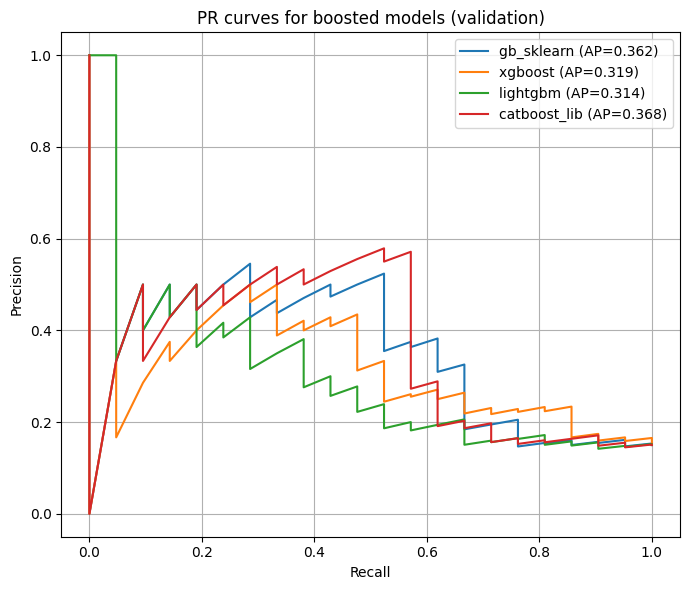

c:\Users\zaits\VScodeProjects\PythonKernel\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


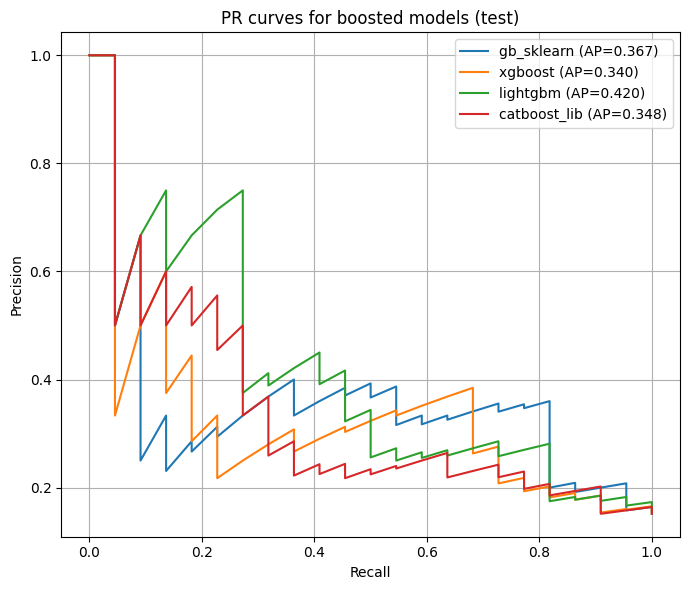

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score


boost_names = ["gb_sklearn", "xgboost", "lightgbm", "catboost_lib"]
boost_names = [n for n in boost_names if n in models]


def plot_pr_for_split(X, y, split_name):
    y_bin = (y == 1).astype(int)

    plt.figure(figsize=(7, 6))

    for name in boost_names:
        kind, model, thr = models[name]
        scores = get_scores(model, kind, X)
        precision, recall, _ = precision_recall_curve(y_bin, scores)
        ap = average_precision_score(y_bin, scores)
        plt.plot(recall, precision, label=f"{name} (AP={ap:.3f})")

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"PR curves for boosted models ({split_name})")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


plot_pr_for_split(X_val, y_val, "validation")
plot_pr_for_split(X_test, y_test, "test")
